In [75]:
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [76]:
import json
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 標題顯示中文請參照https://ppt.cc/fTbrPx

with open('./arma106107.json') as f:
    data = json.load(f)

df = pd.DataFrame(data).transpose()
df.columns = ['avg', 'top', 'btm', 'tn']
dfa = df.avg

In [77]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

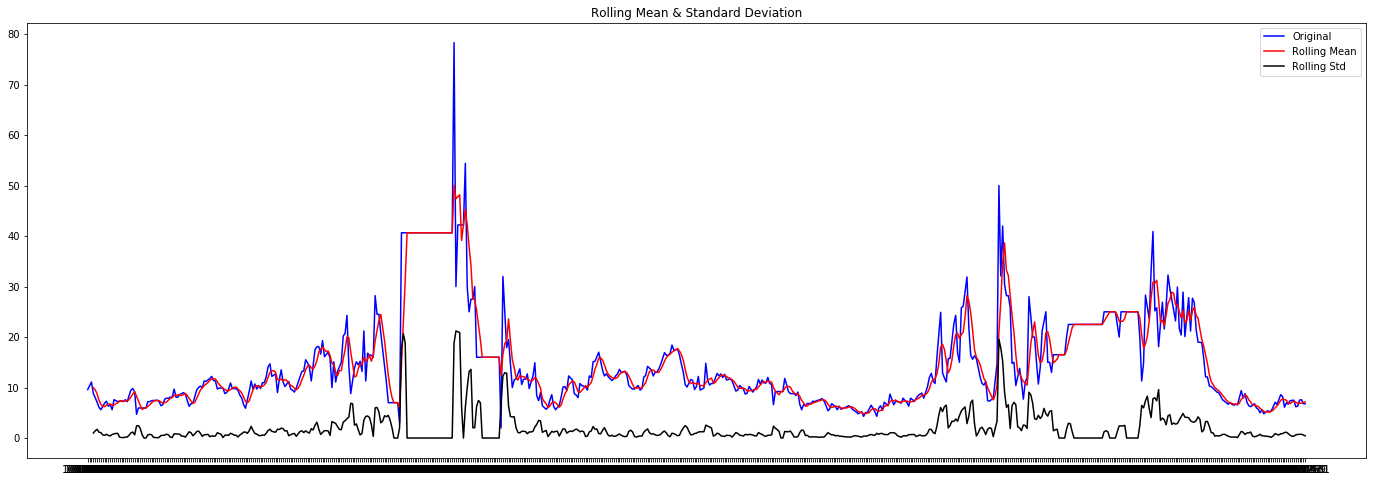

Results of Dickey-Fuller Test:
Test Statistic                  -2.839674
p-value                          0.052826
#Lags Used                      10.000000
Number of Observations Used    638.000000
Critical Value (1%)             -3.440641
Critical Value (5%)             -2.866081
Critical Value (10%)            -2.569188
dtype: float64


In [78]:
test_stationarity(dfa)

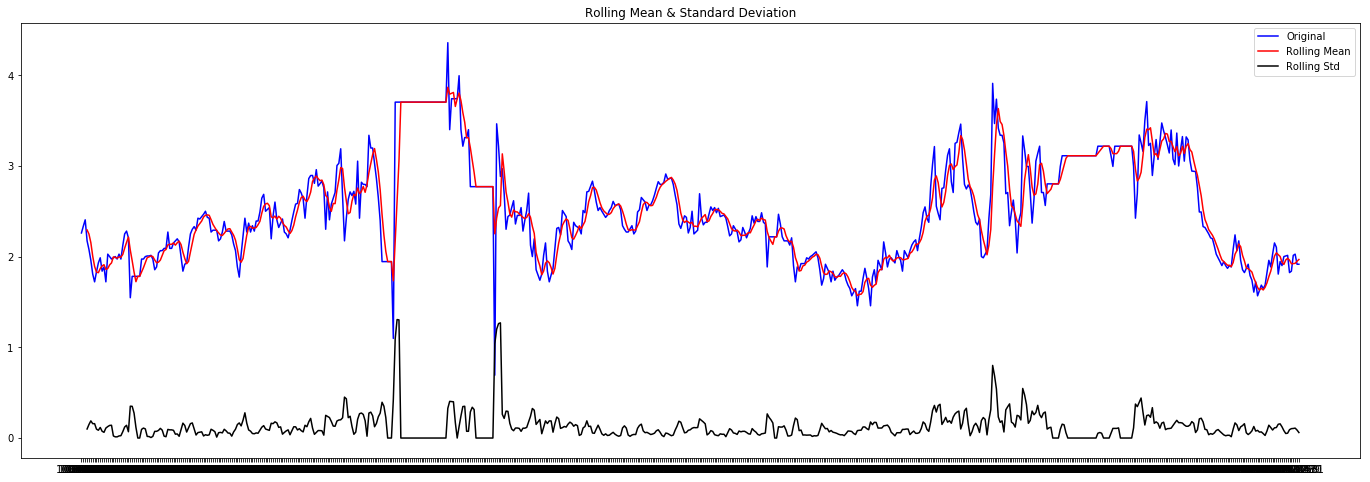

Results of Dickey-Fuller Test:
Test Statistic                  -3.937057
p-value                          0.001778
#Lags Used                       2.000000
Number of Observations Used    646.000000
Critical Value (1%)             -3.440513
Critical Value (5%)             -2.866024
Critical Value (10%)            -2.569158
dtype: float64


In [79]:
dfa_LOG = np.log(dfa)
test_stationarity(dfa_LOG)

In [97]:
dfa_LOG.index

Index(['106.01.01', '106.01.02', '106.01.03', '106.01.04', '106.01.05',
       '106.01.06', '106.01.07', '106.01.08', '106.01.09', '106.01.10',
       ...
       '107.12.22', '107.12.23', '107.12.24', '107.12.25', '107.12.26',
       '107.12.27', '107.12.28', '107.12.29', '107.12.30', '107.12.31'],
      dtype='object', length=649)

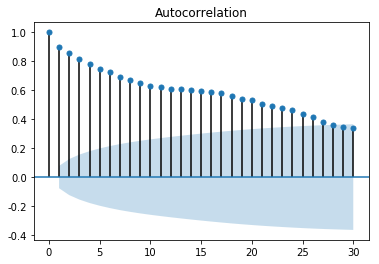

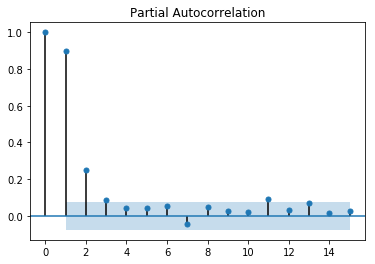

In [81]:
plot_acf(dfa_LOG,lags=30)
plot_pacf(dfa_LOG,lags=15)
plt.show()

In [82]:
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(dfa_LOG,max_ar=3,max_ma=3,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', Va

(1, 1)

In [107]:
MODEL20=ARMA(dfa_LOG,(1,1)).fit()

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


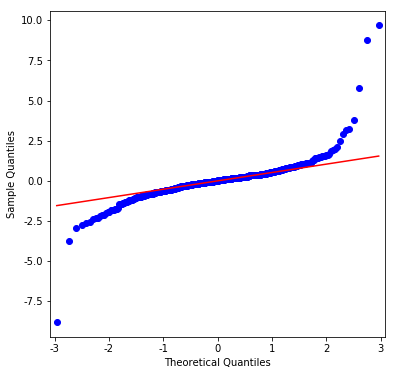

In [108]:
resid = MODEL20.resid
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [109]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

1.9809520870819695


In [121]:
PREDICT_ARMA = MODEL20.predict(start=0,end=653)
PREDICT_ARMA.index=PREDICT_ARMA.index+dfa_LOG[0]

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [105]:
dfa_LOG[648]

1.916922612182061

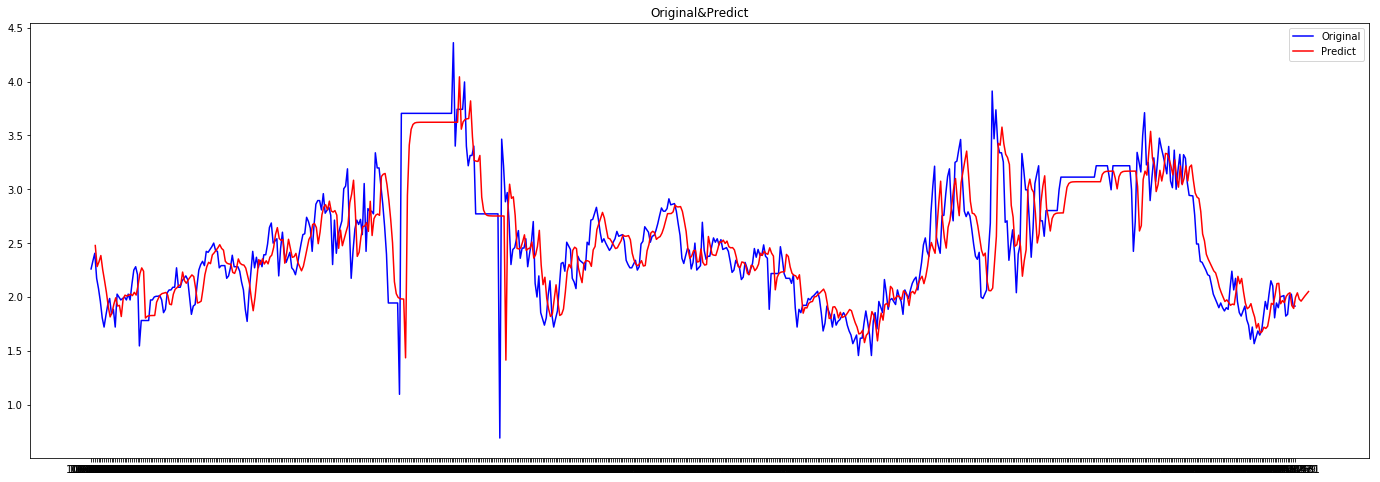

In [122]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(dfa_LOG, color='blue',label='Original')
predict = plt.plot(PREDICT_ARMA, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [190]:
# 对数还原
PREDICT_dfa = np.exp(PREDICT_ARMA)
PREDICT_dfa.dropna(inplace=True)

In [217]:
PREDICT_dfa.index=PREDICT_dfa.index.astype(np.int64)

In [218]:
PREDICT_dfa.index

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
            ...
            646, 647, 648, 649, 650, 651, 652, 653, 654, 655],
           dtype='int64', length=654)

In [234]:
print(dfa[0])
print(PREDICT_dfa[650])

9.6
7.251736795333038


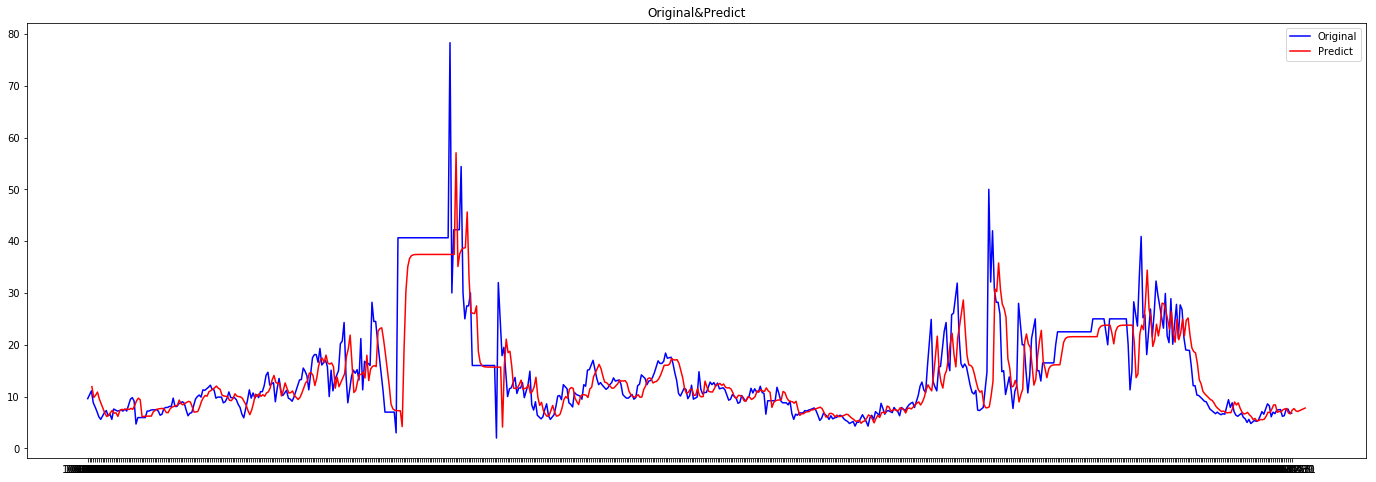

In [166]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(dfa, color='blue',label='Original')
predict = plt.plot(PREDICT_dfa, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [238]:
for i in range(len(dfa)):
    for j in range(2,653):
        er = (PREDICT_dfa[j]-dfa[i])/dfa[i]
        print(er)

0.2425932284150606
0.02244348525750802
0.06879104414455625
0.1322890752474043
-0.007266826926925115
-0.1036345234891963
-0.19576536871113892
-0.29472078730264306
-0.3591440499688718
-0.3324465785539504
-0.2795276412661576
-0.23502295436935117
-0.29105707957180615
-0.28660721969918224
-0.3568613391213171
-0.24218566806737202
-0.21608583458007055
-0.22162160050947965
-0.2164174326863595
-0.20789512849033068
-0.21910253475038566
-0.19505851674433833
-0.21519047972518562
-0.14352886230603973
-0.0438396892481104
0.00942633513246823
-0.021176416984669544
-0.36599015440742494
-0.3553803432224253
-0.3520462303777512
-0.3510063067205129
-0.35068270484975766
-0.350582079813906
-0.26585736711430646
-0.23733254613798624
-0.21452870745698896
-0.2038632915158813
-0.20051851579003727
-0.19602642450116892
-0.21548395200391637
-0.27820700757742595
-0.28261253321369106
-0.20939087155429129
-0.171598434873274
-0.1594864917852351
-0.14200668573428962
-0.13649934682513762
-0.028482762565041897
-0.102492105

0.04538755138693801
0.09819623588989738
0.1027516192048989
-0.011308599670713975
-0.0063216686811101794
0.11663260492563922
-0.014115144056984944
-0.03876327170236195
-0.033704698091117896
0.2533472393874818
0.14899445213487683
0.060775857467221875
0.05366697096575158
0.051466883433767
0.11233357923443268
0.19272827842663148
0.18806025747033414
0.2112766349676101
0.17497399498291788
0.20099492549809397
0.14023922452138962
0.1282487343696032
0.13076937643683803
0.10653205783976973
0.03555011913350717
-0.050031699118748045
-0.062429267805651056
-0.01030907410752048
-0.015430736579861154
-0.039162184975634666
-0.11083669415691301
-0.11923368103593969
-0.04139199749787392
-0.047110405634201845
-0.08712922578918268
-0.06771292900632936
-0.030461255796849183
0.07278162065066561
0.051055738109355986
0.0939384145885581
0.07011943244009118
0.06282146148653578
0.12817678730018311
0.07403824312013359
0.045111047050848264
-0.2357961094099317
-0.14163807507898216
-0.11006888610076329
-0.10002096522

1.730436908689571
2.158150681691357
2.304295565301928
2.3510884499315057
2.3657686646120566
2.3703451224833545
2.371768989224377
2.3722117230508806
2.372349359421096
2.372392145054026
2.372405445147855
2.372409579514232
2.3724108646897415
2.3724112641887287
2.372411388373645
2.3724114269767287
2.372411438976559
2.3724114427067255
2.372411443866256
2.3724114442266955
2.3724114443387405
2.3724114443735687
2.372411444384395
2.3724114443877617
2.3724114443888067
2.3724114443891335
2.3724114443892326
4.139861573231382
2.162400832839591
2.3861597998134725
2.4588903920447835
2.481815533727321
2.4889727614760258
3.110255710672866
1.950112910719446
1.3668325897828535
1.3498273795035698
1.344566216344985
1.4777132500474401
0.6827437092924407
0.49205428655275957
0.43730124912214036
0.4206940471188743
0.41557087083195043
0.4139820903596878
0.41348857877881706
0.41333520500166665
0.41328753190560874
0.41327271297418194
0.4132681065170252
0.4132666745954228
0.41326622948057096
-0.6287195688644226
0.

3.362918562692852
3.391835502769689
3.4008633695890773
4.1845270895987285
2.721165148748392
1.9854365621124626
1.963986808237457
1.957350568344242
2.125297394946202
1.1225517242211465
0.8820230205381396
0.8129595301426995
0.7920118094340344
0.7855496211630282
0.7835455912491515
0.7829230936869168
0.7827296335816475
0.7826695004718472
0.7826508084106156
0.7826449979930657
0.7826431918192264
0.7826426303675381
-0.5316803652721694
0.8370262402678951
1.3941599284276778
1.0999421227206876
1.130132333264174
0.7920145981231191
0.3199584942349354
0.31311458685699184
0.325605390937751
0.4014840090249408
0.4971391139253802
0.29585443629488245
0.3165349194222721
0.3230304783877267
0.4006372098957788
0.20685247151063677
0.24470090356582952
0.3463324678162993
0.5605690362668376
0.13035898153220127
-0.057479222908848826
0.01019039326764877
-0.170938914834289
-0.24801407141106113
-0.29789774752324943
-0.28209289240579805
-0.1744289657579551
-0.058487474603197746
-0.19705632940324042
-0.29154747406853

0.28219750896787765
0.22905879973101273
0.43209133548531375
0.4781454611202489
0.730376813714851
0.8249584165700261
0.9252915817318295
1.0272490524161264
0.9251286993304166
0.7479939723402649
0.5977942010190871
0.5860831820936383
0.5421250495349199
0.4962998306545805
0.44983505265916945
0.4598611370855412
0.5107876327886829
0.5587154886442474
0.6447403929611175
0.6246257095111167
0.6264150289076473
0.6349443503917684
0.5730957958096392
0.38817857409978695
0.3020081777112087
0.25158067284798213
0.23630672279379294
0.25998193484921783
0.2956332494884739
0.23304786144114464
0.23872692582148036
0.4205346337412603
0.5058347744642098
0.6729782742861996
0.7011124910456741
0.6820499492897276
0.57880791342271
0.6040950188753516
0.6199979812064007
0.6724325412399208
0.7595900045558754
0.8768789540249846
1.0036505178678423
1.0056795313142386
1.006310671954524
1.0378303228883086
1.171046920018759
1.136081105580589
1.133170756836559
1.1400912376909766
1.0471756413139195
0.8737268394104867
0.7001590

1.2095803909180987
1.2095058597397546
1.209482692114566
1.209475490470279
1.2094732518322808
1.2094725559484982
-0.41954749498522403
1.276877593571476
1.9674094887554319
1.6027451661890217
1.6401640186936244
1.2210885159835845
0.6360048942630186
0.6275223048368352
0.6430038648242549
0.7370506027351381
0.8556090426117391
0.6061294421683052
0.6317615902698586
0.6398124239171826
0.7360010488849091
0.4958171477878317
0.5427278804759579
0.6686937629272445
0.9342264111476299
0.40100831513850316
0.16819476597213118
0.25206696630356484
0.027568668937782793
-0.06796110259399113
-0.12978875749360483
-0.11019964129169327
0.023242972018309285
0.1669451019002621
-0.004802211091340115
-0.12191799602860089
-0.11241408563757543
-0.06740598467624737
0.09095170905258956
0.3200299994223131
0.40950313824072543
0.3649526283346233
0.6063793713941692
0.6542652754133329
0.6331475605402672
0.3695750544430317
0.26806416595249366
0.19074899098173154
0.41614670294376277
0.4587323226535722
0.4585442415731808
0.444

1.3528867203387112
2.6092543396494015
2.899216603606343
2.757587717443292
3.6169421583267454
4.639369495971276
3.3957908052750665
3.1302271506681794
2.2255613833110557
2.435408380428392
2.9296196479978023
2.5582466430139497
2.896412391830536
3.5964433187419123
3.574650928172279
3.356849610382598
3.072493721170725
2.767095851303817
3.328235150286193
2.6776378926185713
2.359945455140917
3.0867013777088217
2.439018391057418
2.6480791503753047
3.0892798431578603
2.5595435886200764
3.048778688210119
3.1256148802356236
2.590954599912296
2.18613451933833
2.0646510968544285
2.0227020022230793
1.6823809025730834
1.1772620900986155
1.0405372501344747
0.8031221337211305
0.7242599325761759
0.662714198739191
0.6062399539266319
0.5457390120272789
0.5165898440317815
0.4311782200772766
0.3282233920470951
0.2645883114613253
0.21228844946750258
0.1632565022881006
0.18121849095782908
0.15390594202178814
0.12344497399403452
0.13605811739263002
0.12904079533654703
0.27519912955389536
0.46904053779728905
0.

0.32706925414434096
0.4223480737208496
0.1673180079133212
0.058796187453226026
-0.011440028512735125
0.010813207492636394
0.1624040162127993
0.3256496357586977
0.13054468820023757
-0.0024988434884906496
0.008297598715714258
0.059426801407782934
0.23932114148374167
0.4995540793437476
0.601195565041464
0.550586185788132
0.824846965903776
0.8792453528695461
0.8552556287737434
0.5558372618472839
0.44052089252203275
0.35269085375524695
0.6087426545441145
0.657119918534458
0.6569062584271333
0.6412128114788834
0.5731952636556963
0.8330769094212016
0.8920261902339186
1.2148823215550093
1.3359467732096335
1.4643732246167418
1.5948787870926417
1.4641647351429332
1.237432284595539
1.0451765773044315
1.0301864730798571
0.9739200634046975
0.9152637832378631
0.8557888674037369
0.8686222554694928
0.9338081699695141
0.9951558254646367
1.1052677029902305
1.0795209081742294
1.0818112370017885
1.0927287685014635
1.0135626186363382
0.7768685748477273
0.6665704674703471
0.6020232612454172
0.58247260517605

0.3561587377250288
0.5919953623024845
0.5618770419720786
0.4175013480995647
0.33665607871623277
0.3124772353425319
0.30505068622072107
0.2643701384610701
0.3180889686295218
0.09670226919072877
-0.07700698893993163
-0.027728745611086594
-0.031234425583567694
0.010883185057888226
0.02434491929481442
0.028565934009156788
0.07287668029478035
0.07744019510026594
0.0980325485249253
0.11408513642768586
0.13345966187510708
0.15386397694165285
0.11190655106181714
0.010032601293895202
-0.12111592078446723
-0.11873946279510687
-0.023043386166270666
-0.02006777807486425
-0.048486584100950775
-0.11686518902078583
-0.06923317372467133
-0.11286006249309256
-0.10640890206426566
-0.09466550464641839
-0.07162022480402953
-0.04504597779480417
-0.056093106609481067
-0.10898569439200935
-0.1547104412032567
-0.18837122947842191
-0.23875260715088142
-0.233926086378176
-0.2128214666205623
-0.2974338285832507
-0.2479981694305742
-0.23193342975774664
-0.15489761434718977
-0.06325157635462966
-0.0961245887290383

0.2617516477886438
0.27599767258654584
0.28045875889138455
0.2818486699044794
0.5047627397105676
0.4762947383023758
0.33983004135438316
0.26341464974548034
0.24056067450184532
0.2335410595784899
0.19508958292895676
0.24586491555393164
0.03660899416657933
-0.12758194845007229
-0.0810038828378763
-0.08431747075707076
-0.04450767439733845
-0.03178356943366849
-0.027793843196824333
0.014088916990956851
0.018402376190662408
0.037866381482463705
0.05303937552753877
0.07135228314222458
0.09063855354758978
0.0509801647022656
-0.04531165083179761
-0.16927395252230457
-0.16702771140907355
-0.07657525541743385
-0.07376269434473463
-0.10062430552007669
-0.16525613756759203
-0.12023409571236052
-0.16147047002771758
-0.1553727978415661
-0.14427287425483376
-0.12249034947230182
-0.09737222558686963
-0.10781403227471492
-0.15780839606915947
-0.2010276773017083
-0.23284403882206997
-0.2804647930604221
-0.27590273917937175
-0.25595453694272324
-0.3359306050992369
-0.28920374918780295
-0.2740192692230755

1.2344000057852387
1.383338354317441
1.5443181179274188
1.5468946429387156
1.5476960913708242
1.5877210449375345
1.7568849778015987
1.7124839435943988
1.7087882626495987
1.7175761748456846
1.5995881159541834
1.3793356690926817
1.158932146113754
0.8280955252904674
0.6828822776130345
0.7174224058499695
0.8041795303905457
0.8116633744080481
0.6242787291123985
0.6324715443096047
0.8344678509492645
0.6196679776206676
0.5791746250604054
0.5874851388503063
1.0590704647080058
0.8876337427930119
0.742703194410436
0.7310243094437348
0.7274098799269029
0.8274051658851393
0.9594821717008946
0.9518132801298347
0.9899544717325023
0.9303144203290794
0.9730630918897258
0.8732501545708543
0.8535514921786338
0.8576925470033767
0.8178740950224788
0.7012609100050475
0.5606622085906282
0.5402947743192875
0.6259208068233592
0.6175066470473709
0.5785192675400288
0.46076828817078574
0.4469732382980991
0.5748560041106356
0.565461476458097
0.4997162719177713
0.531614473775316
0.5928136511908906
0.76242694821180

0.7018282966966999
0.5366265311613778
0.37868793935233336
0.20905007890975477
0.0986102000533627
0.14437729390751372
0.2350954721151585
0.31138922108111233
0.21533072073404666
0.2229590519442591
0.10252341864917065
0.29911028331307654
0.34385285500559337
0.3343629705551778
0.3432844011090981
0.35789406544514746
0.3386813689993389
0.3798996855811343
0.345387749042539
0.4682362360467891
0.6391319612889537
0.7304451459413741
0.677983285169138
0.086874021015843
0.10506226876155672
0.11077789078099802
0.11256061705054936
0.11311536311470115
0.1132878631761612
0.2585302278040461
0.30742992090630933
0.34652221578801895
0.3648057859727749
0.37053968721707903
0.3782404151408533
0.344884653707572
0.23735941558155554
0.22980708591938684
0.3553299344783578
0.42011696878867316
0.44088029979673987
0.4708456815983607
0.48028683401404987
0.665458121317071
0.5385849625898327
0.5011510182723814
0.5481785982718874
0.5863662714073592
0.6216861907623977
0.5976264326418148
0.43309597322616494
0.249326168820

0.19946465806289795
0.3054727402496059
0.29768517127447514
0.24318585698446835
0.26962778747164357
0.32035868453981725
0.4609591807545249
0.4313719591357677
0.4897713935515232
0.45733370075722946
0.44739501662969017
0.5363986511259072
0.4626705021438662
0.42327622854951047
0.04072503521147461
0.16895341091217564
0.21194566169172369
0.22562934340549803
0.22991433419830362
0.2312493803029868
0.4453642105114663
0.41801994600096626
0.28694201340618386
0.2135430188344746
0.19159117419256197
0.18484864933197057
0.14791499412912953
0.19668603730838172
-0.004309781918943513
-0.16201950311651678
-0.11728004535743379
-0.12046283375350215
-0.08222447672375928
-0.07000263906128681
-0.0661704020180023
-0.02594090867973879
-0.0217977176063374
-0.0031020283128966788
0.011472031756714893
0.02906206143924205
0.04758703169702704
0.009494105569281455
-0.0829967172463319
-0.2020657701858978
-0.19990819648503116
-0.11302623217727197
-0.1103246932521793
-0.13612597767059997
-0.1982065531899239
-0.1549616971

0.20413890976702345
0.23384043331683485
0.26131148170408697
0.24259833649918916
0.11463020139812818
-0.028301868694797904
-0.022028984326107153
-0.010831515851334399
0.10916423478862458
0.26338417267377773
0.3596605671953145
0.41774174398176434
0.40018844321267294
0.5185535034056308
0.5484745993398593
0.5845927481780367
0.6226310314901367
0.6700474141105162
0.613180935953094
0.5868885015496283
0.43121496259802117
0.4043112878283703
0.39605172291822166
0.3934941347540899
0.291147524923149
0.27923805308025235
0.3384763354125104
0.46313227346910296
0.4047747421127922
0.3871128565537582
0.3816680044538529
0.34350375824886487
0.248419597722385
0.16416573466508474
0.014818972018422687
-0.09519778619061071
0.02741900707696655
0.21691460076405752
0.45375436628218424
0.3927568113715496
0.4637951946682396
0.3957399685128156
0.43823579163474025
0.39730031896049783
0.487194202228065
0.5162991818625438
0.6266016080100846
0.8342806312374568
0.9557858188221923
0.7698617305237642
0.7382686613628379
0.

4.305150363340259
5.249840875132715
3.4857881245186095
2.598882431039681
2.573025193491729
2.5650253426615524
2.767481791168025
1.558692489472067
1.268740079552826
1.1854854609939396
1.160233414112261
1.1524433789362534
1.1500275620537719
1.1492771540335436
1.1490439418518492
1.1489714526235968
1.1489489197278657
1.1489419153889016
1.148939738083451
1.148939061264978
-0.4354503033417933
1.2144973855284216
1.8861105986525433
1.5314370794441168
1.5678307579074975
1.1602367758196506
0.5911828423654018
0.5829326526495247
0.5979900603085219
0.6894601752629425
0.8047704387045681
0.5621258958075297
0.5870557932761638
0.5948860561386295
0.6884393763127198
0.45483585606761706
0.500461363202644
0.622976125586772
0.8812339067326264
0.36262452568265374
0.13618942991810015
0.21776376174730275
-0.000583897334485253
-0.09349641485169002
-0.15363016139788965
-0.13457773331109896
-0.004791082009589624
0.1349740032180631
-0.03206790393815274
-0.14597503723329677
-0.13673150794887476
-0.09295650564402144

-0.018239851171622266
0.11963651668808921
-0.04514806739844804
-0.15751591510852256
-0.14839729838199814
-0.10521385016234554
0.04672393706397097
0.266515269716003
0.35236111912285806
0.309616710969706
0.5412558833646757
0.5872004669506301
0.5669388756534994
0.3140517414250708
0.21665615922468975
0.1424753832392288
0.3587353501217182
0.39959452578923804
0.3994140696175112
0.38615946915446225
0.3287122159254191
0.5482068491733121
0.5979950931029717
0.8706776364484874
0.9729280179135417
1.0813963045749506
1.191620597206623
1.0812202154923423
0.8897232133408268
0.7273450821827968
0.7146845211823116
0.6671622157134268
0.6176214385454923
0.567389246118021
0.5782282563086931
0.6332839273391165
0.6850978255613485
0.778097722120127
0.7563521183903964
0.758286517737997
0.7675074058289387
0.7006441035779882
0.5007335936213912
0.40757640833644176
0.3530601868626833
0.336547808425722
0.3621426322694246
0.40068459404159334
0.33302471507150766
0.33916424413133006
0.5357131175581192
0.627929485907253

1.272572709124418
0.8446248263335491
0.7287885035861521
0.527645141069291
0.4608313317659268
0.40868841837625897
0.3608421831878408
0.3095844407453335
0.2848886178602593
0.2125259920099148
0.12530037381767772
0.07138731943251159
0.0270777141321896
-0.014463241117025965
0.0007545548392717816
-0.02238524356487402
-0.048192452588387495
-0.03750631720902188
-0.04345154839542552
0.08037704031649458
0.24460378896714757
0.1630584688004086
0.22059868248627995
0.07935837445459905
-0.02817787680190352
-0.07837305477433579
-0.06548251652628141
-0.03381801946435756
-0.09922696453983877
-0.1472292489925569
-0.22934524336801468
-0.19678990442790115
-0.2631477948881951
-0.25412839489198147
-0.2232816847636126
-0.23228800347574116
-0.21628196867298555
-0.13798812775220978
-0.03125710805263471
-0.04152527414516722
0.04598939814570096
0.16367741869007418
0.16662229955255742
-0.034661262344437435
-0.005666531110377503
-0.024339422711562062
0.033906904981370056
0.05727865746350474
0.06923853089412939
-0.0

0.399979927610242
0.43959249943163764
0.3700531793790496
0.3763632509127559
0.578371815268067
0.6731497494046775
0.8588647492068884
0.890124990050749
0.8689443880996973
0.7542310149141221
0.7823277987503906
0.7999977568960007
0.8582583791554675
0.9551000050620838
1.0854210600277607
1.2262783531864916
1.2285328125713764
1.2292340799494712
1.264255914320343
1.412274355576399
1.373423450645099
1.370189729818399
1.377879152989974
1.2746396014599106
1.0819187104560963
0.8890656278495347
0.5995835846291588
0.4725219929114051
0.5027446051187233
0.5786570890917274
0.585205452607042
0.42124388797334855
0.428412601270904
0.6051593695806062
0.41720948041808403
0.38177779692785463
0.38904949649401793
0.801686656619505
0.6516795249438854
0.5248652951091314
0.5146462707632679
0.5114836449360399
0.5989795201494968
0.7145469002382826
0.7078366201136053
0.7412101627659394
0.6890251177879444
0.72643020540351
0.6390938852494975
0.6218575556563045
0.6254809786279546
0.5906398331446688
0.48860329625441645


0.07319129108544467
0.0028767635165200677
0.052492277113918115
-0.06929577292537561
-0.16202164227229998
-0.20530371190122362
-0.19418851724421865
-0.16688499881956576
-0.22328552630980106
-0.2646767176941807
-0.3354833236227192
-0.30741165411747157
-0.36463043391556943
-0.3568532267332055
-0.3302548659039533
-0.3380207934162079
-0.32421918256832283
-0.2567083257264563
-0.1646767877819125
-0.17353077531080283
-0.09806902195819792
0.003410468810602958
0.005949767278851974
-0.1676121064526885
-0.1426106615562536
-0.15871183754769416
-0.10848745917774073
-0.08833457080991203
-0.07802186557631952
-0.18135099141745786
-0.2028913325209608
-0.11571472998374997
-0.07891082068664756
-0.13152852750502536
-0.1472641852605132
-0.12663202963164719
0.2556731571352191
0.03320604826021859
0.08004147618818311
0.14420790761842958
0.0031829959475282677
-0.09419909742066156
-0.18729974101336144
-0.28729679559003934
-0.35239819786328097
-0.32541970043346563
-0.2719437217005382
-0.22697056441534436
-0.28359

0.24091641306869374
0.26839770192910933
0.20423224222412054
0.1915688164005502
0.1942309230735992
0.16863334680016484
0.09366772786038756
0.0032828483796894545
-0.009810502223315254
0.045234804386445095
0.039825701673309795
0.01476238627573267
-0.06093467189020924
-0.0698029182369364
0.012407431213979981
0.006368092008776513
-0.03589668233857569
-0.015390695430154075
0.02395163290842958
0.13298875242187633
0.11004356014610545
0.15533291744811992
0.13017715568927984
0.12246960473322899
0.19149283148539734
0.13431589962177362
0.10376523846696718
-0.19290711555028509
-0.09346470174157819
-0.06012377256560215
-0.049511937767164914
-0.04618888368294833
-0.045153541805847075
0.12089469386603496
0.09968893771503491
-0.001963336542143242
-0.05888500580183614
-0.07590888532005409
-0.0811377821507168
-0.1097802086345527
-0.07195776698533674
-0.22783207577387465
-0.35013757384546207
-0.31544166782821403
-0.31790995270679767
-0.28825571664291544
-0.27877755682303884
-0.2758056178915121
-0.24460723

0.6261515747760721
0.632983457109711
0.6421587925082506
0.6024157576090218
0.4743005802673852
0.4653020598188437
0.614861198527405
0.6920542606843764
0.7167935486939877
0.7524969823299615
0.7637460149954635
0.9843756339097015
0.8332076150006515
0.7886054685798585
0.8446383298558656
0.8901385361449384
0.9322218443126439
0.903554898466843
0.7075186063971325
0.48855883944626705
0.4981683644366018
0.5153219331639133
0.6991452107400206
0.9353970304789786
1.082884273150269
1.1718596929082348
1.1449695300279246
1.3262947286213917
1.3721313011163803
1.4274612312514605
1.4857326439848901
1.5583705067224929
1.4712559018855909
1.4309781300334732
1.1924995171714368
1.15128537709878
1.1386324265981267
1.1347144191977547
0.9779281232865261
0.9596838259952801
1.0504318329723563
1.2413941210590513
1.1519953496195965
1.1249388440823531
1.116597794056966
1.0581334168918781
0.9124725752342919
0.7834028275720447
0.5546162975601369
0.38607998711225594
0.5739184789264168
0.8642096011704711
1.227027965368452

0.18789578876205373
0.19279074700221546
0.24417631832503944
0.24946846154484625
0.2733486697179806
0.2919642758573164
0.3144322129307965
0.3380943598146899
0.2894378491305107
0.171298310744181
0.019210108670113652
0.021966001128363475
0.13294128326936683
0.1363919884509978
0.10343572600057811
0.024139528698584534
0.07937665568063326
0.028784129209690992
0.036265306849843214
0.04988370049406945
0.07660847879868847
0.10742567280938678
0.09461471670497155
0.03327709389834212
-0.019748242739911097
-0.05878344258842204
-0.11720890577161037
-0.11161176403519567
-0.0871374991061983
-0.18525939785284531
-0.1279306502640272
-0.10930095215604231
-0.019965300671530954
0.08631329800891688
0.04819165340666141
-0.038971440350209004
-0.17213225062422044
-0.0314144697829404
0.07161883253187358
0.0031802352371587098
0.15812432484460787
0.17228214364530142
0.13712478361586614
0.3721772430072952
0.34489598734968263
0.21043938279949728
0.23883673960930235
0.25891202632840876
0.24282578713325648
0.21533841

0.5106926224539785
0.40873836799808577
0.22801623504750307
0.09488671250884081
0.24326333629481667
0.47256892865566624
0.7591649474339036
0.6853527801470852
0.7713151935481218
0.6889626509734912
0.7403861680285933
0.690850806137073
0.7996299589986668
0.8348494301529941
0.9683246349029595
1.2196337050268384
1.3666651925243334
1.141681421810269
1.103451153245787
1.118610575638264
0.7016884614304575
0.8713041808828351
1.124797586043765
0.9490448280269508
0.7970500030374567
0.8070038471926285
0.8640372210206364
0.7159638075825525
0.6501286911458009
0.5857221798652079
0.6533902939822929
0.7923817534617997
0.954048742745501
1.1226822395117275
1.1886027674684876
1.4379803107455982
1.457968607370141
1.3674736506728915
1.0389525837436107
1.27466840651943
1.6675825703208835
1.864441235350115
1.9285462357370469
1.7892605448346008
2.0267909220192006
1.7631576019839212
1.7340033472330096
1.7724037879743453
1.6564589396478713
0.9535995456389111
1.3141761766689701
1.0014643082360117
1.138561358379050

0.23883673960930235
0.25891202632840876
0.24282578713325648
0.21533841146058005
0.31662297452978083
0.294240249974087
0.2535640905160947
0.1493753551456366
0.2939808029752567
0.3095379833583439
0.28082016662734643
0.3382770409266036
0.41124588796662215
0.4674604477094928
0.5072479243260881
0.4077390583814179
0.5039782236900138
0.6579231637641184
0.8971045371871543
1.062062297366598
0.9532651338816797
0.865559889412161
1.3677376147229794
1.9855302468867728
2.6415412364475714
1.538081953774442
1.1539933884281994
0.9573305917413493
1.3742815067648801
1.5314843569629524
1.9271233311603393
2.4006443921309106
2.7329424298862275
2.042655810446038
1.6445675910989053
2.5877828091716255
2.9740431146641733
3.3898541590044537
3.813846771409063
2.878463923294188
2.020170220239344
1.705843145708702
1.6898005126753233
1.62087981482821
1.4040726501790064
1.1407910550327993
0.9194869200499897
0.8221731822495264
0.8688874588566278
0.4431191341198908
0.3200827260609466
0.3176929236244101
0.35013626310132

1.2593499883383898
1.291083685895466
1.1952681515145602
0.614432957854378
0.9124094793306073
0.6539878658339264
0.7672833447715764
0.8821932249930873
0.9972957227448125
1.4634638493396877
1.6711115514759298
2.0365493556791505
1.2473434785148132
0.4979508659174922
0.5551563002526457
0.7923124050706593
0.9755662195884718
0.9838754557687345
1.0475904237998979
0.8885369121142043
1.4973329194516285
0.8177911582774834
1.125105153446326
1.196545121434562
1.219237929160974
1.191280328432308
2.1419732062679624
2.21060546417203
2.232243837325862
1.9154449573741037
1.526686547418212
1.1129799576268127
0.6961733587447265
0.18474690265054636
0.05969532546896793
0.023580368026412266
0.012606733761037183
0.009219590409563277
0.008169001551039513
-0.4154106714846043
1.63577257704244
3.209423567563088
3.8688156342741755
4.094122329840473
4.166261360311071
4.188893357943588
4.1959487304951715
4.198143858387581
4.198826406370108
4.19903859577419
4.19910455695829
4.19912506126961
4.199131435084441
4.19913

0.5862426630968665
0.505823671442317
0.5444278305829077
0.19257761777963195
0.09090169723092116
0.0889267910507278
0.11573760631290342
0.41505245233696153
0.8042238363954821
3.2741165433023185
3.2029852419919935
3.969783328807052
3.2622801876962546
2.8638584183841806
2.747765962059194
2.514814355370406
1.4044174395458824
1.155262107759783
0.6462144830557378
0.6687030963627368
0.8235246647338363
0.6391211428439124
0.24627681238674992
0.4394543960532341
0.5920005056335768
1.83193541317423
2.0676461105520048
1.797045582991495
1.7178946467381366
1.23895039234683
0.6965565506392405
0.8499643972987726
1.4813644533401804
1.8727267819268552
2.1632411985696858
1.3470886671827973
1.1391549932945007
0.8956979799768721
1.1282149160246164
1.206147967177279
1.2309502048881171
1.238716684460585
1.241136411328379
1.2418891200651099
1.2421231522965328
1.537338467756891
1.84419095091934
1.9469372020227564
1.9796260818697498
1.9898611621228819
1.9930499107787587
1.9940418311819608
1.9943502382149114
1.99

-0.02674130707337721
-0.003908297206033932
0.012233318466761062
-0.0007008873725843266
-0.022802223217506603
0.058636040331377835
0.04063911991159696
0.007933288996049101
-0.07584008606533274
0.04043051050037531
0.05293932445704677
0.0298486474909069
0.07604708020449882
0.1347179774866759
0.17991752214479484
0.21190880401894918
0.1318982969418157
0.20927978796697053
0.33305984113466275
0.5253745940896714
0.6580095499096296
0.5705307495399992
0.5000109921624808
0.9037890280542873
1.4005276985103106
1.9279959941706823
1.040755084453774
0.7319271163713225
0.5737995974136525
0.9090506709798698
1.0354502599904818
1.353565381135678
1.7343019098890426
2.0014874943004126
1.44645973948026
1.1263752928430388
1.884771312779888
2.195345477331329
2.529680033253581
2.8705930121464767
2.1184946410270835
1.4283801095167694
1.1756441509414561
1.1627450068132665
1.1073290403010607
0.9330043606169036
0.7213117266817778
0.5433712397699241
0.4651257343763084
0.5026865378644507
0.16034579027207432
0.0614178

0.1036406606526199
0.23209919237827378
0.3007372909089523
0.2613028720734459
-0.18302087010889662
-0.1693491671054071
-0.16505286062099486
-0.16371282476737237
-0.1632958344372717
-0.16316616996154334
-0.05399070124796542
-0.01723388495633132
0.01215092730374571
0.025894282073495162
0.030204328646394885
0.035992795273661456
0.010920008156027164
-0.06990433191185096
-0.07558125085254153
0.01877149437299372
0.06747047318343209
0.0830778092431869
0.10560212308064687
0.1126988282521716
0.251887983808805
0.15652024033598153
0.12838197346648794
0.16373156380168707
0.19243639193036388
0.21898559305629883
0.20090040574418283
0.07722650336463395
-0.06090918853725435
-0.054846803644023015
-0.04402508914491378
0.07194395845343583
0.2209887306377449
0.3140343736652703
0.37016651767365144
0.35320225384312015
0.4675953321504082
0.4965123644626829
0.5314184948834717
0.5681803257354341
0.6140055545766062
0.5590473474982922
0.5336372095513187
0.38318761485983255
0.35718674796835787
0.34920434966593233


0.24766603870702658
0.4646357333182858
0.4369268786143124
0.30410124025159957
0.2297235924189342
0.2074790565151294
0.20064663132306346
0.16322052738418455
0.2126418511391601
0.008966087655470526
-0.15084642982473706
-0.10551044596219962
-0.10873567153688223
-0.06998746974674279
-0.057602674248770684
-0.053719340711575705
-0.012953454128802023
-0.008755020507755281
0.010189944642931319
0.024958325513471043
0.04278288892509856
0.061554858786320686
0.022954026976871825
-0.07077000680961637
-0.19142664712170981
-0.18924030577149828
-0.10119991527296897
-0.09846235582887507
-0.12460765737287467
-0.18751597389912292
-0.1436945198266976
-0.18383125749364512
-0.17789618989912437
-0.1670922642747049
-0.1458906068197071
-0.1214422995712198
-0.13160565808072253
-0.18026683884064856
-0.2223336059069961
-0.25330153112014814
-0.2996523985788109
-0.29521199946792187
-0.27579574929091727
-0.3536391222965906
-0.30815831587612824
-0.2933787553771269
-0.22250580519941454
-0.13819145024625926
-0.16843462

0.7852495642433318
0.6101168329227737
0.5798501988069166
0.5705581882829993
0.567680901598351
0.4525409655385426
0.43914280971528385
0.5057858773390741
0.6460238076527408
0.5803715848768911
0.560501963622978
0.5543765050105844
0.5114417280299729
0.4044720474376831
0.3096864514982203
0.1416713435207255
0.01790249053556292
0.15584638296158734
0.3690289258595647
0.6354736620674573
0.5668514127929932
0.6467695940017695
0.5702074645769175
0.6180152655890827
0.57196285883056
0.673093477506573
0.7058365795953616
0.8299268090113451
1.0635657101421387
1.2002590461749663
0.9910944468392346
0.9555522440331926
0.9696457695386986
0.5820384914861284
0.7397281056645107
0.9753977557750626
0.8120026135563058
0.6706949246988855
0.6799488891868968
0.7329721039176229
0.5953101023619042
0.5341040175496117
0.4742260890934355
0.5371362889366629
0.6663549114215169
0.816654690521208
0.9734311445460592
1.0347166353808595
1.2665598201462984
1.285142689664428
1.2010106596099537
0.895588730199138
1.114730784186032

4.375024050847622
3.189738111277798
2.936622752980609
2.0743631934683493
2.274373612595811
2.7454187269979045
2.3914538316226706
2.7137680609634782
3.380985038175884
3.3602141659142037
3.1526222848959127
2.8815955779908475
2.590513233273951
3.1253491276165266
2.505248616402076
2.2024480119311862
2.8951372506287196
2.277814403976601
2.4770754402014616
2.8975948505098357
2.39268998290351
2.8589921872002697
2.9322266827245778
2.4226286030414066
2.0367844637443455
1.9209955766893767
1.881012845868872
1.55664429776497
1.0752029296252426
0.9448870665344211
0.7186007837029523
0.6434352482366675
0.5847744706732912
0.5309474560863209
0.47328249583850013
0.4454996950927917
0.3640917410111541
0.2659629205448874
0.20531073436157551
0.15546242839871327
0.10872885374334576
0.12584887419418073
0.0998166009895167
0.07078349083806404
0.08280539313985036
0.07611700805514626
0.21542417035605638
0.400179262588041
0.30844077740045966
0.3731735177970649
0.2142781712614239
0.09329988859785851
0.0368303133788

0.3321532560705222
0.27694420751274046
0.48788710180292333
0.5357355440210378
0.7977940921712737
0.8960606925402869
1.0003029420590435
1.1062327817310404
1.0001337135900432
0.8160976336002752
0.6600459231367138
0.6478786307466372
0.602207843672644
0.5545972266541096
0.5063221326329033
0.5167388437252376
0.5696494886116186
0.6194446635264907
0.7088211874920701
0.6879228150764849
0.6897818482157374
0.6986434809265126
0.6343852423996251
0.4422634536101682
0.3527357690506064
0.3003435562056957
0.28447451718835626
0.3090721401030834
0.34611246700101184
0.2810886872115788
0.2869890138404991
0.47588013895195874
0.5645036617809971
0.738159246011636
0.7673896010864146
0.7475843628984182
0.6403199100495688
0.6665922274029626
0.6831147856689878
0.7375922506388787
0.8281454592788315
0.950004108077906
1.0817148237587972
1.0838228896771311
1.0844786202124925
1.1172263094943466
1.2556331636558535
1.2193050447590537
1.2162813058042172
1.223471415782833
1.126935731235241
0.946729183803103
0.76639902863

-0.01535257085078977
0.13432244057765344
0.060002655109233145
0.11244436884825512
-0.016280975180618613
-0.11428869784477284
-0.1600362018196478
-0.1482878631631932
-0.1194290810308069
-0.17904229679580244
-0.22279121427169743
-0.2976311078797096
-0.2679604192254289
-0.32843849660696267
-0.32021828395218566
-0.29210482662000137
-0.30031311709181474
-0.28572533853740456
-0.21436892655897602
-0.11709508582012279
-0.12645341441078534
-0.04669320675328522
0.06056676133778911
0.06325070338967256
-0.1201976061873354
-0.09377202835376179
-0.11079035993965151
-0.057705099257485536
-0.036404261552248865
-0.025504123742059317
-0.1347190858652878
-0.1574864084240536
-0.06534405004611556
-0.02644371553588707
-0.08205863350214715
-0.09869062619307414
-0.07688322119294362
0.5099867079474153
0.2424629694268451
0.2987840536440176
0.3759462180221621
0.2063592989242428
0.08925424993717909
-0.022702220205941034
-0.14295184279814863
-0.22123833920267968
-0.1887958422934081
-0.12448928558925483
-0.07040764

1.1442438716234657
1.1097097339067548
1.1068353153941324
1.1136703582133103
1.021901867964365
0.850594409294308
0.6791694469773643
0.42185207522591905
0.3089084381434713
0.33577298232775415
0.4032507458593133
0.40907151342848197
0.2633279004207544
0.2697000900185815
0.42680832851609457
0.2597417603716304
0.22824693060253753
0.23471066355023826
0.601499250328449
0.4681595777278982
0.3554358178747835
0.3463522406784604
0.3435410177209245
0.4213151290217751
0.5240416891006958
0.5180769956565381
0.5477423669030573
0.5013556602559506
0.5346046270253423
0.45697234244399787
0.4416511605833819
0.44487198100262637
0.41390207390637246
0.32320293000392586
0.2138483844593775
0.19800704669277921
0.26460507197372385
0.25806072548128856
0.22773720808668904
0.13615311302172228
0.12542362978741042
0.2248880031971611
0.21758114835629766
0.1664459892693777
0.19125570182524582
0.2388550620373594
0.37077651527585054
0.3430156653619549
0.3978101964187131
0.36737483034011653
0.3580496452327957
0.441559228216

-0.33932857258947663
-0.2869551913561971
-0.24290931566451246
-0.2983657694731277
-0.29396178444455145
-0.36349163459429323
-0.2499981869532754
-0.2241674239142966
-0.22964612009185612
-0.2244956034834073
-0.2160611580935231
-0.22715302408285587
-0.2033568825510977
-0.22328129952183315
-0.15235846166370937
-0.05369701203936696
-0.0009801219307530558
-0.03126738175802343
-0.37252633838260607
-0.362025906694359
-0.35872616614705266
-0.35769696335226014
-0.3573766975832653
-0.35727710991891726
-0.27342584786570534
-0.24519509720872862
-0.222626349648154
-0.21207088644870725
-0.20876059294684096
-0.2043148118774455
-0.22357174631315432
-0.28564817244776175
-0.29000828029396225
-0.2175414811258965
-0.18013865719416805
-0.16815157949878937
-0.1508519776339361
-0.14540141541456916
-0.03849840418808267
-0.1117447638656636
-0.1333561131623365
-0.10620617006983818
-0.08415967836276167
-0.06376879708562606
-0.07765896672225125
-0.17264562370448208
-0.27873953140232416
-0.27408336980906917
-0.2657

0.37077651527585054
0.3430156653619549
0.3978101964187131
0.36737483034011653
0.3580496452327957
0.44155922821690063
0.37238219954239293
0.33541967123163946
-0.023517250912690493
0.09679579295463392
0.13713420109346913
0.14997321109651665
0.1539936962848281
0.15524633213613578
0.3561441975169313
0.3304878505688078
0.20750114838111078
0.13863295594345765
0.1180361634399347
0.1117098438176514
0.07705604387424499
0.12281652883255569
-0.06577214105974948
-0.2137466942821639
-0.1717689314464811
-0.17475525142303908
-0.13887728680253958
-0.12740988356367652
-0.12381420436257005
-0.08606801308222406
-0.08218057454421782
-0.06463894014543392
-0.0509645134134527
-0.03446028803231611
-0.017078834457110434
-0.0528203453917853
-0.13960185815705214
-0.2513209695571387
-0.24929657941805394
-0.16777769932682307
-0.16524292206377317
-0.18945153460451356
-0.24769997583252118
-0.2071245553950903
-0.24428820138300472
-0.23879276842511513
-0.22878913358768968
-0.20915796927750657
-0.1865206477511294
-0.19

-0.18648528541890053
-0.1812335682730199
-0.1718589435034427
-0.0713973848281282
0.057716981773395355
0.13832047486119356
0.18694657635682602
0.17225078966642393
0.2713471191302956
0.29639733898220794
0.3266357891723099
0.35848179380569595
0.39817923041810666
0.3505700859142183
0.3285578152508517
0.19822648031462245
0.1757024735307287
0.16878748895479032
0.16664625235226138
0.08096071854031087
0.07098999792765319
0.12058483895000877
0.22494794988110953
0.17609048176884934
0.16130378688221628
0.15674530605438855
0.1247938441153288
0.04518850041874101
-0.02534961748969642
-0.15038411644969257
-0.24249116983399963
-0.13983524988905122
0.018812223895490095
0.21709667874787525
0.16602895835757647
0.22550295367573556
0.1685264852665434
0.20410438369420122
0.1698328251762308
0.24509282047000794
0.2694597801639902
0.3618059974037918
0.5356768075476384
0.6374020808743937
0.4817447046245468
0.4552946932340039
0.46578289826135727
0.17733097040828175
0.29468138095963603
0.47006344615818624
0.34846

-0.2901354525068508
-0.27206585808497774
-0.25122923258910784
-0.25989118586425225
-0.3013637831028255
-0.3372161413980081
-0.363609259477399
-0.4031128396978502
-0.39932840863743346
-0.3827804681456682
-0.4491242519573216
-0.41036220103079113
-0.397765984696415
-0.337362902158592
-0.26550407691442557
-0.29127950707163236
-0.35021364432769814
-0.44024851036524
-0.34510410172823813
-0.2754395393676537
-0.3217133636748757
-0.21695003036074814
-0.20737741423982464
-0.23114858380518147
-0.07222106864847658
-0.09066691764424871
-0.18157791731170358
-0.16237743174143765
-0.14880380038022367
-0.15968029165421865
-0.17826550588744877
-0.1097833297213414
-0.12491710371070258
-0.15241973425332236
-0.22286552691857528
-0.12509252526104805
-0.11457374988839251
-0.13399091006446467
-0.0951422280098533
-0.045805337113477104
-0.007796629105513455
0.019105130652298137
-0.04817643211710954
0.016894367154043355
0.12098213913596635
0.2827013632117691
0.39423530333309753
0.32067358484045383
0.261372879772

0.4489348189709969
0.1637984305185314
0.27979998577619203
0.4531661651678623
0.3329674398575124
0.22901695610032974
0.23582447020645297
0.2748300534566423
0.17356145461105613
0.1285362887721283
0.08448815749402165
0.13076692519478667
0.2258243026549092
0.3363896573949118
0.4517194626545724
0.4968030421192532
0.6673543504524496
0.6810245073393495
0.6191342783337592
0.3944560773878718
0.555664025148346
0.8243811831504896
0.9590144080842742
1.0028563336362564
0.9075977289386065
1.0700466650591087
0.8897457162993485
0.8698068869007365
0.8960692572927994
0.8167736426327399
0.3360824478794854
0.5826837070322269
0.36881754413842205
0.46257931981095995
0.5576771517184171
0.6529343912370864
1.0387287029018106
1.2105750770835282
1.5130063633206765
0.8598704649777765
0.23968347524206268
0.2870259036573621
0.483293024886063
0.6349513541421837
0.6418279633948148
0.6945575921102606
0.562927099680721
1.066758278166865
0.5043788896089519
0.7587077131969594
0.8178304453251549
0.8366106999952889
0.81347

0.6580095499096296
0.5705307495399992
0.5000109921624808
0.9037890280542873
1.4005276985103106
1.9279959941706823
1.040755084453774
0.7319271163713225
0.5737995974136525
0.9090506709798698
1.0354502599904818
1.353565381135678
1.7343019098890426
2.0014874943004126
1.44645973948026
1.1263752928430388
1.884771312779888
2.195345477331329
2.529680033253581
2.8705930121464767
2.1184946410270835
1.4283801095167694
1.1756441509414561
1.1627450068132665
1.1073290403010607
0.9330043606169036
0.7213117266817778
0.5433712397699241
0.4651257343763084
0.5026865378644507
0.16034579027207432
0.06141786757603138
0.059496337238545936
0.08558253587201411
0.3768077914629896
0.755461030006415
3.158599879969823
3.08939104626248
3.8354648604609154
3.147083425866626
2.7594298124819048
2.646474990111648
2.4198193727928268
1.3394331844230205
1.0970117805230324
0.6017221997299069
0.6236030126772574
0.7742402143356245
0.5948205714156986
0.21259365529521612
0.40055022318693045
0.5489734649407774
1.755396618223575


0.9121711421767744
1.124416856236444
1.1601428457722847
1.1359364435425112
1.0048354456161397
1.036946055714732
1.0571402935954295
1.123723861891963
1.2344000057852387
1.383338354317441
1.5443181179274188
1.5468946429387156
1.5476960913708242
1.5877210449375345
1.7568849778015987
1.7124839435943988
1.7087882626495987
1.7175761748456846
1.5995881159541834
1.3793356690926817
1.158932146113754
0.8280955252904674
0.6828822776130345
0.7174224058499695
0.8041795303905457
0.8116633744080481
0.6242787291123985
0.6324715443096047
0.8344678509492645
0.6196679776206676
0.5791746250604054
0.5874851388503063
1.0590704647080058
0.8876337427930119
0.742703194410436
0.7310243094437348
0.7274098799269029
0.8274051658851393
0.9594821717008946
0.9518132801298347
0.9899544717325023
0.9303144203290794
0.9730630918897258
0.8732501545708543
0.8535514921786338
0.8576925470033767
0.8178740950224788
0.7012609100050475
0.5606622085906282
0.5402947743192875
0.6259208068233592
0.6175066470473709
0.5785192675400288

0.9996273187091576
1.6442348558899595
0.9247200499408649
1.2501113389431684
1.3257536579895364
1.3497813367586782
1.3201791712812672
2.326795159577842
2.3994646091233256
2.422375827756795
2.08694171957258
1.6753151678545772
1.2372728963107427
0.7959482622002988
0.25443789692410795
0.1220303446142014
0.08379097791031892
0.0721718357469806
0.0685854486689494
0.0674730604658066
-0.38102306392487517
1.7908180227508188
3.4570367185962114
4.155216553937362
4.393776584536971
4.470159087388193
4.4941223789990925
4.501592773465476
4.503917026528027
4.504639724391879
4.504864395525613
4.504934236779366
4.504955947226645
4.504962695971761
4.5049647938317845
4.504965445955131
4.504965648668744
4.504965711682601
4.50496573127056
4.504965737359508
4.50496573925227
4.504965739840635
4.504965740023533
4.504965740080384
4.504965740098057
4.504965740103552
4.504965740105258
4.504965740105791
4.504965740105953
7.390068156304168
4.162154300664627
4.52740790851905
4.646129904661338
4.683551827113716
4.6952

0.7177890257972915
0.741255404900247
0.9028083458092205
0.7103872794892998
0.30046276075139117
0.502039369794679
0.6612179189219931
1.9550630398339788
2.201022028402092
1.9186562605128643
1.836063979205012
1.3362960615793007
0.7703198789279031
0.9303976319639365
1.5892498643549708
1.9976279463584574
2.3007734245944547
1.449136000538571
1.2321617321333918
0.9781196312802143
1.2207459993300345
1.302067444011074
1.3279480398832524
1.3360521924806101
1.3385771248643952
1.3393625600679406
1.339606767613773
1.647657531572408
1.9678514270462675
2.075064906458528
2.109175041951043
2.1198551256934417
2.123182515595226
2.1242175629724804
2.124539379006864
2.124639422795603
2.1246705222218574
2.124680189591898
2.124683194715613
2.1246841288637714
2.1246844192452956
2.1246845095108666
2.124684537570067
2.1246845462923143
2.1246845490036392
2.1246845498464593
2.124684550108451
2.3436428883879157
2.4147835897823597
2.437204682955472
2.444204264430283
2.446382998427047
2.4470605421742437
2.4472711848

2.9403965297595533
2.940396529759935
2.9403965297600507
5.005522469775615
2.695015709949417
2.956460397676794
3.041440352810221
3.0682265709866594
3.0765892265667247
3.8025093040493485
2.4469740325248264
1.7654570259568076
1.7455877802620656
1.7394405264662456
1.8950123237396403
0.9661531761206411
0.7433476400774348
0.6793730384479745
0.6599688340020531
0.6539828069720683
0.6521264424202667
0.6515498130994599
0.6513706079493157
0.6513149057002375
0.6512975909487809
0.651292208667261
0.651290535579915
0.6512900154983513
-0.5661881278310622
0.7016664120376293
1.2177481442277438
0.9452095452570582
0.9731752139710245
0.6599714172087842
0.2226983946597297
0.2163587751938452
0.22792920423707466
0.29821676625468213
0.3868236002677207
0.20037042519947015
0.21952708325431528
0.22554402208547325
0.29743236285082675
0.11792649992564258
0.15298610014518954
0.24712902281930893
0.44557973885770236
0.04706937236667074
-0.1269281222734599
-0.06424468834154633
-0.23202762637281502
-0.3034235608860355
-

1.1560323395748313
1.3071135929876618
1.3562006769498285
1.3716712312392758
1.3765009424568955
1.378004268914663
1.3784717741002286
1.3786171175684956
1.2228956817088608
1.0178859709809671
1.260108585875613
1.3411722332805103
1.3669585700106441
1.3750320146642878
1.377547264138132
1.3783296760872414
1.3785729425625899
1.3786485674095394
1.378672076005468
1.3786793837378917
1.0608239317981325
0.3654909647324606
0.4352608994066138
1.201645147186135
1.3785221281998692
1.2921285076404083
1.816334716579315
2.4400153925424783
1.6814323912177904
1.5194385619075894
0.9675924438197437
1.095599112061319
1.3970679852786592
1.1705304522385092
1.3768115590166263
1.8038304244325662
1.7905370661850903
1.6576782623333846
1.4842211699141423
1.2979284692953286
1.6402234416745773
1.2433591144973284
1.0495667276359595
1.4928878404023809
1.0978012185450248
1.2253282817289357
1.4944607043262947
1.1713215890582465
1.4697549998081727
1.5166250769437302
1.1904823059465002
0.9435420567963814
0.8694371690812013


-0.28312796071498186
-0.2532917818187872
-0.2959478839482488
-0.3087044608665326
-0.2919783929538111
0.20493888816005867
-0.008539650659386236
0.036403436746236285
0.09797728508839197
-0.037349650353382
-0.13079711368649344
-0.22013611511383172
-0.3160928846571085
-0.3785639272425424
-0.3526754701129216
-0.30136013698536496
-0.2582040769642194
-0.31254019837266056
-0.308225182738601
-0.37635038945097427
-0.26514973873199715
-0.23984080928976545
-0.24520882473646516
-0.24016235896859106
-0.23189830641486617
-0.24276609430340432
-0.21945068290360087
-0.23897258640018004
-0.1694825331452507
-0.07281424411937985
-0.02116234168972785
-0.05083773768210387
-0.38520257397083635
-0.37491427221568513
-0.37168119309357694
-0.3706727822744368
-0.3703589865209772
-0.37026141072863616
-0.2881041135653881
-0.26044368110350186
-0.23833086783708027
-0.2279886463184304
-0.22474522743276346
-0.2203892601223457
-0.23925716557955531
-0.3000795224993222
-0.30435154735873077
-0.23334872393143402
-0.196701512

-0.22462078535387486
-0.07371403210338706
-0.11257973080750826
-0.06731633614059074
-0.11067895811572813
-0.08360197347166996
-0.10968475252074479
-0.05240723397857812
-0.033862468193777494
0.03641872368784146
0.16874518096545915
0.2461644155327242
0.12769950971425675
0.10756941254977277
0.11555158628740453
-0.10397819951228125
-0.0146672675882417
0.11880934840357524
0.026266966969943056
-0.053765706365233
-0.048524522938394744
-0.01849367565727555
-0.09646153494547019
-0.13112692811349427
-0.1650400911329215
-0.12940953546950065
-0.056223766982503684
0.028901771622631037
0.11769551549511312
0.15240588198561952
0.28371529636604514
0.29424010742056095
0.24659010809767287
0.07360777639597195
0.19772362998146978
0.4046120613636511
0.5082677301179808
0.5420221329765865
0.4686814373244136
0.5937527421251542
0.4549369674163124
0.439585833277558
0.4598055343758719
0.39875492839865795
0.028665247482435475
0.21852639390976747
0.05386837469064337
0.12605664445622564
0.19927355928763077
0.2726132

-0.31243486720126623
-0.3340440769133246
-0.3893943425788805
-0.31257269841939483
-0.3043079463408797
-0.31956428647922214
-0.28904032200774177
-0.2502756220177319
-0.2204116371543319
-0.19927454020176563
-0.2521386252348717
-0.20101156866468012
-0.11922831925031202
0.007836785380675846
0.09547059547600538
0.03767210237464244
-0.008921308749789374
0.2578606078215828
0.5860629436585981
0.9345687818627725
0.34835603794267234
0.14430898760248104
0.03983187686259192
0.26133705046884265
0.3448510646365685
0.5550342696789303
0.8065923333195463
0.9831256658770585
0.6164108992994577
0.40492653277129365
0.9060096173724262
1.1112104046653422
1.3321100219711162
1.557356097311065
1.0604339592500376
0.6044654295021514
0.437479171157748
0.42895652235876547
0.3923424016274867
0.27716359540759716
0.13729524798617476
0.01972742627655709
-0.031970496929939
-0.007153537482416412
-0.23334295999880797
-0.29870605178012205
-0.29997563432453206
-0.2827401102274192
-0.0903234234976675
0.15985818053995288
1.74

0.14416722988599479
0.13017440661642904
0.13141915054445033
0.1373525915768824
0.09432751012844466
-0.03431055714797429
-0.09425518072263743
-0.12933518410575157
-0.1399605406651875
-0.1234908279309789
-0.0986899133993225
-0.1422275746496385
-0.13827692116766582
-0.011801993919123255
0.047537234409885054
0.16381097341648668
0.18338260246655588
0.17012170385372355
0.09830115716362434
0.11589218704372282
0.1269551173609744
0.16343133303646665
0.22406261186495682
0.30565492453911974
0.39384383851675986
0.3952553261316442
0.3956943804901037
0.41762109418317117
0.5102935095782671
0.48596946475171415
0.4839448743210845
0.4887591218719837
0.424122185261857
0.30346214915512115
0.1827193496101435
0.0014784182026038256
-0.07807318704677242
-0.059151203751755824
-0.011623387699092392
-0.0075235427155910225
-0.11017773970364261
-0.10568950181299919
0.00496934443307526
-0.11270362965128648
-0.13488694453212577
-0.13033422828200614
0.1280125154487336
0.0340950069213891
-0.045301728279500346
-0.05169

0.009212935085107636
0.07834237986062285
0.14845688304662946
0.2186889155731059
0.5031304843428601
0.6298307771717536
0.8528097763466003
0.3712604275683605
-0.08599608181305562
-0.051091071032284024
0.09361434885667343
0.20543023568110136
0.2105002780961769
0.24937720774231056
0.15232760739171783
0.523796357631502
0.10916070674558304
0.29667433091640205
0.34026481985837675
0.3541112788100857
0.33705240378920476
0.9171361936550277
0.9590135035625943
0.9722165787073054
0.7789155672113173
0.5417070458822987
0.2892759063485636
0.03495323584423989
-0.2771035848233955
-0.35340624208673144
-0.37544248730591795
-0.3821382641458078
-0.3842049956823004
-0.3848460329519081
-0.6433014266685722
0.6082680131106413
1.5684618378351047
1.9708027598961069
2.108278031767068
2.15229506730845
2.166104421796087
2.17040939487841
2.1717487949483543
2.172165264903794
2.17229473640459
2.172334983906753
2.172347495011965
2.17235138411932
2.1723525930556042
2.172352968855499
2.172353085673513
2.1723531219865837
2

-0.3561891622899481
-0.3573546806913737
-0.34153190447107334
-0.1648870773093341
0.0647878378727436
1.5224294353915322
1.4804503067493733
1.9329868825746537
1.5154440451977897
1.2803098862595164
1.2117963054775571
1.0743166687431904
0.41900045612543885
0.27195796523528204
-0.028463583770384195
-0.015191615261335587
0.07617849066259207
-0.03264981733801884
-0.2644923730176557
-0.15048593019809126
-0.060458717986741496
0.6713061454798734
0.8104140980306914
0.6507154260277677
0.604003398074966
0.3213477725325554
0.0012464889018469415
0.09178226725829211
0.4644118085286312
0.695379740153554
0.8668308712870277
0.3851670822718149
0.26245212719019717
0.11877257834700657
0.2559956881456754
0.30198896423577143
0.3166263504257741
0.3212098465669026
0.3226378820954368
0.3230821036449829
0.323220221027462
0.4974456531024276
0.6785389218540367
0.7391760536527744
0.7584678515952622
0.7645082268266189
0.7663901112792675
0.7669755069270588
0.7671575176350298
0.7672140997778413
0.7672316887976082
0.767

2.312716853198335
2.312720914390086
2.3127221768191264
2.312722569247335
2.312722691234288
2.3127227291541317
2.3127227409415756
2.3127227446057215
2.312722745744729
2.3127227460987894
2.312722746208851
2.312722746243063
2.312722746253698
2.3127227462570046
2.3127227462580313
2.312722746258352
2.3127227462584496
4.04889057193525
2.106429136683138
2.3262277679583665
2.3976710930705396
2.4201904800330323
2.4272210311844145
3.0375078219883904
1.8978985229191017
1.3249417474858116
1.3082375143796126
1.3030694691530382
1.433859918188193
0.6529606347916893
0.46564624608279903
0.4118622889606864
0.39554901973623924
0.39051651913580954
0.3889558586719056
0.38847108180928036
0.38832042261225647
0.38827359328781025
0.3882590366383556
0.388254511711414
0.3882531051335568
0.38825266789684393
-0.6352909039287692
0.43060450569535197
0.8644785283330588
0.6353531575169957
0.6588641179402417
0.39555119145871226
0.027932278696232864
0.022602510118719343
0.032329861969222
0.09142117516986542
0.1659136462

1.2216452945986662
1.2223815654134143
1.2226104860976663
1.2226816512669756
1.2227037735392599
1.2227106503282577
1.2227127879935806
1.2227134524907242
1.2227136590507774
1.2227137232603076
1.2227137432199449
1.22271374942443
1.2227137513531046
1.2227137519526363
1.2227137521390015
1.3784676216367648
1.429072862834875
1.4450218878755423
1.450000971605047
1.451550792695529
1.4520327568043596
1.452182595431439
1.2916450326895474
1.0802948154442962
1.3300088514181578
1.4135796219386705
1.4401634742377776
1.448486613055967
1.4510796537506518
1.4518862640074655
1.4521370541882372
1.4522150179479791
1.4522392536138848
1.4522467873586513
1.1245607544310647
0.4077226440540832
0.47965041175939577
1.2697372651403454
1.4520846682472879
1.3630190800416582
1.9034378521436237
2.5464076211778126
1.7643632899152482
1.597359342172773
1.02844581837087
1.160411455733319
1.4712041085347003
1.2376602600397004
1.4503211948625017
1.890546829311924
1.8768423362732891
1.739874497250912
1.5610527524888067
1.368

0.8934509629014881
0.5929018649983282
0.1732964393199426
0.16721296609510392
0.17831590305577869
0.24576356357772522
0.3307903234892269
0.15187061003989558
0.17025326170868632
0.17602709190020155
0.24501085324069227
0.0727577524538994
0.1064008031696263
0.1967399713922661
0.3871724766816335
0.004763539139734514
-0.16220375369675447
-0.10205298376208995
-0.26305681318603463
-0.33156806347649875
-0.37590910890955503
-0.36186034880515383
-0.26615908067373784
-0.16309997742506463
-0.28627229280288036
-0.37026442139424914
-0.36344848565927135
-0.3311699486061977
-0.2176002894673348
-0.053311818596118964
0.01085578601102523
-0.02109457967920966
0.1520498522119798
0.1863922682257235
0.17124724038746422
-0.01777950640954302
-0.09058024461992886
-0.1460285014171421
0.015620362717243921
0.04616156473134968
0.04602667829995786
0.0361191991659617
-0.006821171934535204
0.15724552362449593
0.1944609786830294
0.3982842939109906
0.47471387197577863
0.5557911771570339
0.6381810524574758
0.5556595550144

1.4212807932107667
1.1924550022611202
1.400819756582451
1.8321519438712788
1.818724309277869
1.6845234973064487
1.509314313044588
1.3211398679750792
1.6668923653278556
1.266019307573059
1.0702694218545044
1.5180685256589705
1.1189911298434592
1.247806345180743
1.5196572770972674
1.1932541303618651
1.494702020008255
1.542045532266394
1.2126083898449496
0.9631737947438195
0.8883203728092941
0.8624729508647254
0.6527801520904857
0.34154532824258116
0.2573007298808379
0.11101464805039342
0.06242278673885581
0.024500667910006498
-0.010296594045206704
-0.04757495218521204
-0.06553555064708416
-0.11816291490188018
-0.18159972813259803
-0.22080922223090066
-0.25303438972204395
-0.28324599353965524
-0.2721785055714387
-0.2890074498653629
-0.30777632915519093
-0.3000045943338341
-0.30432839883303675
-0.21427124340618578
-0.0948336080238927
-0.15413929541788465
-0.1122918672827055
-0.21501209130574617
-0.29322027403774803
-0.32972585801769877
-0.32035092111002283
-0.2973221959740782
-0.3448923378

0.6221852591733565
0.7113702948727373
0.8019991577032235
0.7112255105159259
0.5537724198580132
0.4202615120169663
0.4098517174165674
0.3707778218088177
0.33004429391518264
0.28874226903037287
0.29765434407603664
0.342922340256607
0.38552487879488656
0.46199146040988226
0.44411174178765933
0.44570224791790874
0.4532838670149053
0.39830737405301264
0.23393651031092175
0.15734060240996328
0.11251615364265079
0.09893930915003818
0.11998394208819363
0.15167399954531013
0.09604254350323968
0.10109060073020476
0.2626974522144536
0.338519799523742
0.4870917993655108
0.5120999920405992
0.49515551047975787
0.40338481193129777
0.4258622390003125
0.43999820551680063
0.48660670332437406
0.5640800040496671
0.6683368480222085
0.7810226825491932
0.7828262500571009
0.7833872639595769
0.8114047314562742
0.9298194844611191
0.8987387605160791
0.896151783854719
0.9023033223919792
0.8197116811679285
0.665534968364877
0.5112525022796278
0.2796668677033271
0.17801759432912412
0.20219568409497868
0.26292567127

-0.27864749618285617
-0.3159057726160017
-0.30633753804012637
-0.2828339938292138
-0.3313849633697772
-0.36701552502540297
-0.4279676033247119
-0.40380281565782344
-0.4530581570304128
-0.44636334466208927
-0.4234668175564959
-0.43015192010570474
-0.4182711520046902
-0.3601561360634959
-0.2809331111318525
-0.28855484266445397
-0.22359549828360334
-0.13623944179705824
-0.13405355084758616
-0.2834599060700978
-0.2619380437107956
-0.2757983343838398
-0.23256394681795206
-0.2152158418827593
-0.20633841005796574
-0.29528667817894566
-0.3138291367577343
-0.23878536034683628
-0.20710364461170175
-0.2523982685223672
-0.2659439120541531
-0.2481832420025004
0.09439403603528265
-0.09949931573650676
-0.058679447358923005
-0.002754575928891693
-0.12566619619252126
-0.21054049775195274
-0.2916832605162325
-0.378836656706915
-0.43557641098175864
-0.4120630416621949
-0.36545553726193697
-0.3262587488023644
-0.37560990494397606
-0.37169076230386694
-0.43356595005180226
-0.33256719389419925
-0.3095801845

1.3962965363372934
1.6277420449434794
1.1171431507890293
0.6486250284792747
0.47704281807034643
0.4682856009557956
0.43066375213099534
0.3123148870243199
0.16859695205918862
0.04779331874288425
-0.005327483083974114
0.020172511944672945
-0.212242307521711
-0.27940438348049246
-0.28070890866373943
-0.2629990123437702
-0.06528645350219056
0.1917808827566487
1.823269643282265
1.776283829572693
2.2827926575606217
1.8154511331571588
1.5522734506757887
1.4755885253968988
1.3217122347400845
0.5882390426358122
0.42365937393306785
0.08740773192672585
0.10226259576254172
0.20453005376913963
0.08272222279597882
-0.17677127989132116
-0.04916773838685452
0.05159666427172043
0.8706362362251793
1.0263350455022415
0.8475897428934646
0.7953065556435397
0.4789397087061628
0.12066120776170014
0.22199483124322592
0.639066427894431
0.897580993566363
1.0894804247432786
0.5503704957537743
0.4130198120844407
0.2522041702599522
0.40579333902543474
0.45727205171343216
0.47365518121049927
0.4787853328546982
0.48

0.04183516888940681
0.0018638481956647678
-0.037240105081838074
0.003844107060677796
0.08823177888752125
0.18638673666691127
0.2887713597035488
0.3287945373915817
0.48020233152411324
0.492338083046157
0.4373947164799697
0.23793549727290642
0.38104867538679676
0.6196037034091079
0.7391250357482839
0.7780459288403497
0.6934796165067217
0.8376944883688002
0.6776314012045235
0.6599306036771843
0.6832451569844237
0.6128500705004933
0.186114009852196
0.40503553583473184
0.21517475857186427
0.2984122533015663
0.38283583877043137
0.467400939159454
0.8098918076781376
0.9624493031251727
1.2309342204989675
0.6511094944190463
0.10053533006183098
0.14256381243051514
0.3168009506641578
0.4514364062282649
0.4575411511770293
0.5043521480978841
0.38749650685941534
0.8347752061277268
0.33552003465284486
0.5613017453891371
0.6137882524825352
0.6304605193835725
0.6099202412972057
1.308388478074421
1.358812177759042
1.374709758035327
1.1419595605197495
0.8563411368786862
0.5523934382564337
0.24616818193490

0.39275769957484474
0.5635864689160447
0.6208434044567765
0.639065456652494
0.6447714416445112
0.6465492001596251
0.6471022106600806
0.6472741527076565
0.8641670375356749
1.0896096782264537
1.1650967198534534
1.1891130397410403
1.19663269053926
1.1989754446537817
1.1997042025010323
1.1999307872599347
1.200001226254047
1.200023122788859
1.2000299294065404
1.200032045258952
1.2000327029755125
1.20003290742781
1.200032970982141
1.2000329907381084
1.2000329968792824
1.2000329987882767
1.2000329993816907
1.2000329995661543
1.354197543864961
1.4042864050508452
1.4200726849380363
1.4250009616907096
1.4265349682802682
1.427012014387988
1.427160324049485
1.268260899702919
1.0590673173275174
1.3062332508934824
1.3889512584495
1.4152638469496368
1.4235020557798852
1.4260686368756448
1.4268670164155524
1.4271152475128466
1.4271924157240197
1.4272164040872122
1.427223860957032
1.1028815630593187
0.39335812727802094
0.46455193817001394
1.2465766808021783
1.4270633961223151
1.338906640449396
1.873810

0.8552592850611181
0.8485690195570176
0.8464942591755922
0.845849791111161
0.8456495030021763
0.8455872475473243
0.8455678957662845
0.8455618802751741
0.8455600103540227
0.8455594290863926
-0.5151514369876578
0.9018624605126445
1.4786596906074783
1.1740577270520063
1.205313474438204
0.8552621721745235
0.3665452646196979
0.35945980756959167
0.3723914635590835
0.4509481505199388
0.5499793179462761
0.34159047522293723
0.36300085775482294
0.36972567174258775
0.4500714643626887
0.249447264622777
0.28863152369168243
0.39385008432746293
0.6156479434291967
0.17025400440980848
-0.024213783717396353
0.045844171853565874
-0.14167793535785206
-0.2214733915785103
-0.27311766802406995
-0.25675499449070854
-0.1452911645494123
-0.025257620765663468
-0.16871714102923707
-0.266543267270949
-0.2586047068266807
-0.22100970484721844
-0.08873445479136641
0.10261329363510854
0.17734968017754707
0.14013690131480291
0.3417992396351295
0.3817980535805486
0.364158550568929
0.14399798665241464
0.05920653861914172

2.0109865616935334
1.6086378883520664
0.7284695756107096
0.8167859486159668
1.7868925913748541
2.0107875040504672
1.9014284906840608
2.564980653897867
3.3544498639778206
2.3942182167313804
2.1891627365918853
1.4906233466072705
1.6526571038750875
2.0342632725046315
1.747506901567733
2.0086222266033245
2.5491524359905897
2.5323254002342916
2.3641496991561826
2.1445837593849904
1.9087702142978842
2.34205498946149
1.8396950816421878
1.5943882628303283
2.155554228357444
1.65544458043674
1.8168712426948552
2.15754519534974
1.7485083405800588
2.1262721516559147
2.185601363219911
1.7727624125905064
1.4601798187295965
1.3663761633939255
1.3339850903241495
1.0712055070501023
0.681177056911589
0.5756047121291512
0.3922841792023917
0.33139058084995854
0.2838679256087423
0.24026123024714602
0.19354531308435452
0.17103772767010972
0.10508698005966914
0.025590214112313846
-0.023545734188090722
-0.06392917193015633
-0.10178928304336546
-0.08791989938699282
-0.10900933590722697
-0.132529830207138
-0.12

0.933100599474339
0.9907260093957054
0.9653131660738806
0.6481326926348345
0.5259755217394414
0.43293522643564286
0.7041765408306296
0.7554236425153156
0.7551973076558615
0.7385728935157662
0.6665204064149324
0.9418187599800864
1.004265032027456
1.346273645715052
1.4745198868746114
1.6105648565855313
1.748812274462544
1.6103439990920903
1.3701613184274777
1.1665006115513044
1.1506212638557807
1.0910170163185353
1.0288811263112956
0.9658780375039585
0.9794727282515812
1.048525603781265
1.1135125269752506
1.2301564650320236
1.2028823179811752
1.205308513773081
1.2168736954464656
1.1330112485554429
0.8822760326776771
0.7654348172355371
0.6970585394548909
0.6763480987034479
0.7084500811514817
0.7567908467640323
0.6719293036490096
0.6796297299274309
0.9261486559203529
1.0418098636802844
1.2684451176762028
1.306593208197524
1.2807456939521729
1.1407564927765559
1.175044093390307
1.1966074321442721
1.2677051406642992
1.38588475194017
1.5449206156270976
1.7168142615157183
1.719565466188798
1.7

0.01499851314659
-0.026979007664241363
-0.06633359684770875
-0.05191673752068982
-0.07383865179830164
-0.09828758666268282
-0.08816387946117855
-0.09379620374303464
0.023515090826152833
0.17909832638992934
0.10184486517933455
0.1563566465659495
0.022550038956988643
-0.07932640960180327
-0.12687973610200226
-0.11466764723542444
-0.08466970265044393
-0.14663607166932088
-0.19211192009821174
-0.26990602003285596
-0.23906411998432733
-0.30192948989407953
-0.2933847951608245
-0.2641615960918435
-0.2726938980296495
-0.2575302861112494
-0.18335717365998816
-0.08224357604986439
-0.09197131234805309
-0.00906267544091481
0.10243123875901773
0.10522112589189658
-0.08546856432630909
-0.0579998715782523
-0.07568997941095347
-0.020509247912386192
0.0016324123338466651
0.012962818741806855
-0.10056326030733856
-0.12422929296710827
-0.02844973623214634
0.011986137798222744
-0.04582410587723182
-0.06311262459543224
-0.04044440097687551
0.28267688094457855
0.05542553316904042
0.10326817460083212
0.16881

0.9100973084920749
1.3298032641788224
0.6238266263395622
0.37809254420943933
0.2522706474044116
0.5190295661560254
0.6196055832182328
0.8727294430541954
1.1756810895891308
1.3882803718089305
0.9466453841025725
0.6919545340901598
1.2954094316743194
1.542532960457186
1.8085626071049996
2.079826697836981
1.481382832645206
0.9322594419810853
0.7311577115018038
0.7208938763890507
0.6767994514223493
0.5380894912435576
0.3696458900478662
0.22805883594596105
0.16579897143921307
0.19568606238676717
-0.07671410236415595
-0.15543094407928687
-0.15695990370266238
-0.13620314349968773
0.09552447922861532
0.39681845398359894
2.3089934528792138
2.2539240583163815
2.847574190044169
2.2998298227325837
1.9913742593942039
1.9014962286909884
1.7211465977061202
0.8614844693258442
0.6685900189107998
0.27448863204315177
0.29189917137760263
0.4117610307616797
0.2689970138146418
-0.03514053234574204
0.11441630662185863
0.232516520490511
1.192466126328436
1.3749518275241326
1.1654546448966412
1.1041765007004927

0.13564249123918687
0.14690122563285
0.18402303804596157
0.24572743685371704
0.3287638612566262
0.41851364096838384
0.4199501106649476
0.4203969358970081
0.44271173301827144
0.5370243681548735
0.512269809260594
0.5102093853710151
0.5151088408431692
0.4493278876558721
0.32653227568884
0.20365243544395126
0.019203699940702944
-0.06175589832193659
-0.04249901266771617
0.005870003669065201
0.010042412280593143
-0.09442867314972483
-0.08986099742030897
0.022756412476138476
-0.09699926911414117
-0.11957520903711921
-0.11494191373832488
0.14797733873101201
0.05239757341557291
-0.02840441373577475
-0.03491565048712143
-0.036930774908009965
0.018818809298794443
0.09245466209872873
0.0881790853821201
0.10944364353227992
0.07619299540470786
0.10002632556683819
0.044378404760741716
0.033395964665963895
0.03570469434701526
0.01350502642846155
-0.05150940415647804
-0.12989629078575604
-0.14125158599898135
-0.09351317849671133
-0.09820425872580212
-0.11994058535378936
-0.18558936146230534
-0.19328040

0.11484999932566188
-0.08266752724560025
-0.041084670674042964
0.015885525455615106
-0.10932350827088606
-0.19578424537348452
-0.2784436952922368
-0.3672261269257358
-0.4250264373552494
-0.40107356580541337
-0.35359489309860864
-0.31366545438745524
-0.36393906204573256
-0.3599466644030046
-0.4229783977163219
-0.32009181434081974
-0.29667514130548384
-0.3016418098028976
-0.2969726498868272
-0.2893264704212312
-0.29938171342090675
-0.2778095103500605
-0.295871832276802
-0.23157729702224122
-0.14213654362447287
-0.0943464656755425
-0.12180314047222686
-0.43116873666460553
-0.42164965373226937
-0.41865830015200106
-0.4177252845342919
-0.41743495014557697
-0.4173446697395792
-0.34132997423339645
-0.3157376114882867
-0.29527809267169103
-0.285709121360043
-0.2827082010826502
-0.2786779135711422
-0.2961351345081866
-0.35241002549002703
-0.3563626466216293
-0.2906684455066538
-0.25676121259658224
-0.24589442253628568
-0.23021160589244674
-0.2252704420113384
-0.12835836641349552
-0.194759271915

0.05054555426788015
0.02522385417548264
-0.051253586033407135
-0.06021325760020365
0.022844621226495387
0.016743020792372294
-0.025957472878148487
-0.005240084042835931
0.03450783530954756
0.14466904883859685
0.12148730818884897
0.16724356608160584
0.14182846657267467
0.13404145632841707
0.2037762627378243
0.14600987796839002
0.11514426154394639
-0.18458657034977244
-0.08411897701726444
-0.05043432692194842
-0.03971309176476441
-0.036355779391019825
-0.03530976388631959
0.13245030926671592
0.11102593707292203
0.008325701225463675
-0.04918278936680339
-0.06638217279758028
-0.07166497578113644
-0.10060268501222838
-0.0623903212841545
-0.21987158170968768
-0.34343796120469355
-0.3083843654346904
-0.3108780965491357
-0.28091814671139903
-0.27134227390368865
-0.268339696426476
-0.23681968102742418
-0.23357346946475918
-0.21892530053381593
-0.20750644934525428
-0.19372457041873817
-0.1792101607322262
-0.2090561647086042
-0.2815232011414559
-0.3748144178776106
-0.3731239477614677
-0.305051480

2.3752547350499484
2.6140744017239945
2.6917003222785674
2.7161685023435833
2.7238074665753738
3.3869075373527706
2.148678202787101
1.526138629479776
1.5079888377393869
1.5023735578297435
1.644482411108325
0.796005305110201
0.592481017378426
0.5340426793515151
0.5163176849057215
0.5108496794456393
0.5091539618262051
0.5086272331196988
0.5084635361075479
0.5084126542454093
0.5083968378859056
0.508391921378748
0.508390393077807
0.5083899180033016
-0.6037295398456819
0.5544068186882191
1.0258276317464967
0.776874103840582
0.8024196666081473
0.5163200445657162
0.11688795666032997
0.11109695810976239
0.12166610002425086
0.18587108455956533
0.26681001947532174
0.09649221532643906
0.11399108566499949
0.11948732786653801
0.18515456221950516
0.021182860509000395
0.05320845686339427
0.139204395844561
0.32048149222578576
-0.04354240024198349
-0.2024824193844105
-0.14522351338891254
-0.2984867740905522
-0.36370421427089783
-0.40591347867351874
-0.39254013972798296
-0.3014398941028851
-0.2033355554

1.4265349682802682
1.427012014387988
1.427160324049485
1.268260899702919
1.0590673173275174
1.3062332508934824
1.3889512584495
1.4152638469496368
1.4235020557798852
1.4260686368756448
1.4268670164155524
1.4271152475128466
1.4271924157240197
1.4272164040872122
1.427223860957032
1.1028815630593187
0.39335812727802094
0.46455193817001394
1.2465766808021783
1.4270633961223151
1.338906640449396
1.873810935285015
2.510219788308651
1.736155501242643
1.5708556754159075
1.0077473916527997
1.138366440878897
1.4459877400802643
1.2148269920801111
1.4253179173639043
1.8610514535026184
1.8474868022296838
1.711916594217739
1.5349195611368798
1.3448249686687024
1.6941055527291604
1.2891419535687023
1.091394620036693
1.543763102451409
1.1406134883112495
1.2707431446213628
1.5453680656390762
1.215634274549231
1.5201581630695638
1.5679847723915612
1.2351860264760204
0.9832061804044706
0.9075889480420419
0.8814777768939572
0.6696452556832456
0.35523456628587274
0.2701303291653362
0.1223515322141729
0.0732

-0.33372259822299016
-0.39566427656779335
-0.4357534409319264
-0.4230518222073993
-0.33652738800639304
-0.24335066452129123
-0.3547119359587685
-0.43065002482219783
-0.42448767196591647
-0.39530433709601426
-0.2926249192444396
-0.1440901373608746
-0.08607559072975791
-0.11496222272366892
0.04157931843822843
0.07262862606709258
0.05893586117222804
-0.11196503319218949
-0.17778487869746984
-0.22791617936344347
-0.08176789124194377
-0.05415529764014951
-0.054277249756202385
-0.06323469664447288
-0.1020574979134153
0.04627677478379094
0.079923624562739
0.2642022383304848
0.33330295274522465
0.4066057218132088
0.48109519811223855
0.406486720971994
0.27707322180110683
0.16733822905504087
0.15878223349306916
0.12666670285656256
0.0931870908891913
0.05924022112085447
0.06656521430907128
0.1037717865122798
0.1387875716122356
0.20163681677524575
0.18694115763369268
0.18824842294622643
0.1944798906971825
0.14929373209836663
0.014194392036374097
-0.04876114870413971
-0.08560316138960203
-0.0967622

0.6062331047903978
0.544989395934877
0.5238415052529573
0.3522746698922156
0.09762799583483919
0.028700597175231064
-0.09098801523149623
-0.13074499266820883
-0.16177218080090372
-0.19024266785516908
-0.2207431426969916
-0.23543817780215973
-0.27849693037426554
-0.33039977756303474
-0.3624802727343732
-0.38884631886349047
-0.41356490380517247
-0.40450968637663165
-0.4182788226171151
-0.4336351783997016
-0.42727648627313697
-0.4308141444997573
-0.35713101733233377
-0.25940931565591213
-0.30793215079645103
-0.2736933459585772
-0.35773716561379226
-0.4217256787581574
-0.4515938838326626
-0.4439234809082005
-0.425081796706064
-0.46400282187494535
-0.49256616468978587
-0.5414285745660914
-0.5220568026347842
-0.5615424895202483
-0.556175573820022
-0.5378205066361992
-0.5431796384318459
-0.5336553863178095
-0.4870673156872653
-0.42355794859330326
-0.4296679317227441
-0.3775930854009052
-0.3075638500356583
-0.3058115242331889
-0.4255835610644586
-0.4083304978508031
-0.41944163996059886
-0.3847

-0.447393546029635
-0.45951205734519773
-0.43526607138203605
-0.40447425295025513
-0.3807525061084055
-0.3639627553375727
-0.40595408529294774
-0.36534252262726363
-0.30037994153216274
-0.19944879459123624
-0.12983895962189648
-0.17574981939035497
-0.21276018851047102
-0.000848311517607997
0.25985141623945385
0.5366787487136915
0.07103458333034962
-0.091045343181008
-0.17403425383964333
0.0019131181029104522
0.0682504910588345
0.23520452626978855
0.43502369738857566
0.5752487558739755
0.28395759376978197
0.11597001184670132
0.5139934549341257
0.6769898249823995
0.852456187665
1.0313750560201367
0.6366567619574766
0.2744689936470989
0.1418274267352324
0.13505766315022502
0.10597410625729432
0.01448455805426154
-0.09661654060672648
-0.19000374650372773
-0.23106876351881683
-0.21135600140447264
-0.3910241951763581
-0.4429438141799551
-0.4439522769102666
-0.43026164784021953
-0.2774200243385728
-0.07869421120230698
1.1825275965799074
1.1462052299533583
1.5377616998163668
1.1764835001002154

-0.2445286671565785
-0.29142412097349185
-0.3188676610351117
-0.32718001480609904
-0.31429554566028955
-0.2948934696661366
-0.32895354479393485
-0.3258628975121195
-0.2269199272156406
-0.18049808192423955
-0.08953563304152398
-0.07422449466902087
-0.08459866705320941
-0.14078480902165438
-0.12702311897940047
-0.11836844560195876
-0.08983263061773013
-0.04239999752061196
0.02143072327890324
0.0904220505403224
0.09152627554516392
0.09186975344463899
0.10902330497322921
0.18152213334354236
0.16249311868331384
0.16090925542125664
0.16467550350529347
0.11410919255179297
0.019715286754006404
-0.07474336595124825
-0.21653048916122827
-0.27876473816584235
-0.26396182606429874
-0.2267802012611947
-0.2235728395394079
-0.3038805446661149
-0.3003693381530265
-0.21379949245031524
-0.30585658101971386
-0.323210874974112
-0.3196492262070116
-0.11754122941085463
-0.1910141102315663
-0.25312720239552744
-0.25813243880982795
-0.2596814800313273
-0.21682635747779738
-0.16022192641390232
-0.16350859423007

0.4538475176430944
0.5763937025103848
0.7920619148270398
0.3263010692874308
-0.11596342339295533
-0.08220283919515985
0.057758140697438363
0.16590793287188507
0.17081174438810567
0.20841402060321856
0.11454637436248132
0.4738358213157152
0.07279478193425258
0.25416041842733983
0.29632171101056126
0.30971418770155845
0.2932146200584113
0.8542792692728959
0.894783552626116
0.9075537400611644
0.7205904666470121
0.491159273886158
0.24700456515680755
0.001020342865740345
-0.3008051066324644
-0.37460603742815
-0.3959197828040845
-0.4023960259770928
-0.40439499582386423
-0.405015015478075
-0.6549964618597665
0.5555379143201286
1.4842499742995277
1.8733993907191857
2.0063672766271643
2.0489411306753866
2.0622977194421175
2.0664615458660034
2.067757031179556
2.068159846382359
2.0682850729159155
2.0683240008278436
2.0683361017328847
2.068339863328523
2.068341032627552
2.0683413961061388
2.068341509094054
2.068341544216532
2.0683415551344106
2.0683415585282505
2.068341559583233
2.068341559911174


-0.12916221410564793
-0.10683691725325814
-0.31031655839250194
-0.36911709075802146
-0.37025920517548266
-0.3547541553853088
-0.18165641310633543
0.04340655598774875
1.4717782419097747
1.4306420676580205
1.8740915636474518
1.4649331205954246
1.234520531113743
1.167382725046281
1.0326637235877045
0.390506471062679
0.24641664063216392
-0.04797234714848893
-0.034966884031188285
0.05456848080992957
-0.05207451980111083
-0.2792616024751325
-0.1675444456559609
-0.07932500879022059
0.6377457811128078
0.7740604012830872
0.6175685299227924
0.5717944944991634
0.2948146847306969
-0.01885886228092107
0.0698589285583264
0.4350059489196225
0.6613359702709525
0.8293443076065653
0.3573524822261961
0.23710168286910888
0.09630726552879358
0.23077489119495903
0.2758446075242098
0.29018807029674243
0.29467952836274797
0.29607888847906255
0.29651418991717204
0.2966495338582359
0.4673764632810937
0.6448333210135943
0.7042528397240038
0.7231572521656384
0.7290763347216667
0.7309204303298845
0.731494071044989

-0.14309588633547332
-0.09349192558453712
-0.027973410888532595
-0.03177766418756232
-0.012857230557892545
-0.042442452907622025
-0.021236418983836776
-0.07074992332311947
-0.08052170073028399
-0.07846747668336426
-0.09821993711483332
-0.1560674225959213
-0.225813235108586
-0.23591676549515656
-0.19344085960730997
-0.19761481288201282
-0.21695500901557627
-0.27536691216724796
-0.2822101258836201
-0.2187722184333067
-0.22343249593023534
-0.25604625881244414
-0.24022274135555186
-0.20986409429113298
-0.1257252146665835
-0.1434309535880445
-0.10848326055184436
-0.12789479324764222
-0.1338423522530988
-0.08058033475929957
-0.1247011168272927
-0.14827564275777325
-0.37720391593644037
-0.3004688249659421
-0.2747411788301496
-0.26655251890694603
-0.26398827244825923
-0.26318934722025983
-0.13505763780416188
-0.15142113467658713
-0.2298614722923624
-0.27378528006755853
-0.2869218170186243
-0.2909567137855924
-0.31305874367075714
-0.2838729225556141
-0.40415388524283236
-0.4985313561957108
-0.4

-0.4625506867425429
-0.3924336831290812
-0.36882693473488515
-0.34995479237819777
-0.34112824125452246
-0.3383601509986515
-0.3346425582078639
-0.35074533958944804
-0.40265407523649044
-0.40630002748719257
-0.34570279025182726
-0.31442629092960606
-0.3044026138912291
-0.2899365675042397
-0.28537876978632076
-0.1959857345365864
-0.2572348456462877
-0.2753064049719538
-0.2526034353170199
-0.23416800690679213
-0.2171170113560839
-0.22873206700050322
-0.30816056464943764
-0.3968770219484952
-0.3929835075127561
-0.3860333546663455
-0.31155323357947434
-0.2158305135128276
-0.15607275139601168
-0.12002236580442209
-0.1309175180059271
-0.057449549610298106
-0.03887783489250103
-0.016459673544666792
0.0071502954076711036
0.03658115358583766
0.0012847188674377011
-0.015034723176092703
-0.11165967838743508
-0.12835851100308046
-0.13348513749903476
-0.13507260601470278
-0.19859808797873504
-0.20599017395018818
-0.16922158491637282
-0.0918489337088326
-0.12807084972309446
-0.1390333993804259
-0.142

0.8586402244250706
0.8586459748434566
0.8586477623739422
0.8586483180310366
0.8586484907579777
0.8586485444504295
0.8586485611408159
0.8586485663290492
0.8586485679418201
0.8586485684431527
0.8586485685989925
0.9888910284376395
1.0312074801291626
1.0445441648614446
1.0487077090145651
1.0500036800988475
1.0504067018105419
1.0505319979038756
0.9162893807835008
0.7395568715353166
0.9483694705824249
1.0182519252418192
1.040481525871245
1.0474413919519723
1.049609710463907
1.050284203523484
1.0504939160022326
1.05055910983581
1.050579375866783
1.0505856756361136
0.7765723549983902
0.17714738339005232
0.23729387879880504
0.897969954470806
1.0504501105171287
0.9759728514141451
1.427874755671823
1.9655305108124812
1.3115796476015436
1.1719297947479221
0.6962003826032275
0.8065509586735511
1.0664379183436719
0.8711469415849218
1.048975481910885
1.4170951934763505
1.4056354018836985
1.2911019502874004
1.1415699740639158
0.980972818358042
1.2760546910987738
0.9339302711183867
0.7668678686516892
1

-0.4394632846358497
-0.5282480165692983
-0.5030613588678887
-0.5048531508538234
-0.4833263720815238
-0.47644593013820596
-0.47428852261754206
-0.45164080784933447
-0.4493083447265307
-0.4387833640872604
-0.43057870804807163
-0.4206761728193897
-0.4102473006742663
-0.43169220723507123
-0.4837611148942313
-0.5507925817342832
-0.5495779476508323
-0.5006666195960938
-0.49914575323826393
-0.5136709207627081
-0.5486199854995127
-0.5242747332370542
-0.5465729208298028
-0.5432756610550691
-0.5372734801526138
-0.525494781566504
-0.5119123886506777
-0.5175586989337347
-0.5445926882448048
-0.5679631143927756
-0.5851675172889712
-0.6109179992104505
-0.6084511108155121
-0.5976643051616207
-0.6409106234981059
-0.6156435088200711
-0.6074326418761815
-0.5680587806663414
-0.5212174723590329
-0.5380192342392862
-0.5764355607469439
-0.635124954904749
-0.57310489594137
-0.5276939219581742
-0.5578576000251041
-0.48956742719811724
-0.4833274996526264
-0.49882278055448864
-0.3952255854893773
-0.4072495463162

0.04102778057130898
0.050930400022721596
0.11108642156932255
0.18692109932822945
0.027344057603150177
0.043739395578017606
0.048889027910990646
0.11041508532277967
-0.04321605862219776
-0.013210094470333235
0.06736267718769687
0.23720788460794348
-0.10385954617266915
-0.25277632086467283
-0.19912833686889098
-0.34272634689565246
-0.40383097553309344
-0.4433783944328463
-0.4308484192045966
-0.3454932341144148
-0.2535756555412738
-0.36343204493229864
-0.43834394340568167
-0.4322648655879987
-0.4034759001082303
-0.30218404195735266
-0.15565648685599795
-0.09842592058476123
-0.1269221926868626
0.027503922243117204
0.05813364463375346
0.04462591710233303
-0.12396550571661939
-0.18889589385020678
-0.23834974450718074
-0.09417643325218779
-0.06693698280717454
-0.06705728692165915
-0.07589368723035841
-0.11419185604972053
0.03213789944887481
0.0653300620686479
0.24711842429899172
0.3152853452756945
0.3875975363833006
0.4610803981377488
0.3874801436615616
0.2598154755605513
0.1515633881218646
0

1.7358206531226377
1.6055669238562595
1.435510950896218
1.2528710483287537
1.5884543545829193
1.199371680879734
1.0093791447411369
1.444007686669001
1.0566678613186518
1.1816943938518978
1.4455497101238186
1.1287466559394574
1.4213284311844832
1.4672794871997357
1.147531672496569
0.9054333890160603
0.8327815383149033
0.8076943346628219
0.604168971146648
0.30208811270603475
0.22032129664904868
0.07833774663714667
0.03117505771712487
-0.0056317046755818235
-0.039405517749759346
-0.07558745359152923
-0.09301979915746394
-0.14409929975770713
-0.20567032436399213
-0.2437265980476388
-0.2750039664949249
-0.3043269937296653
-0.29358502011345516
-0.3099189954575581
-0.3281358488859205
-0.32059269450048594
-0.3247893282791238
-0.23738091271776846
-0.12145614896436635
-0.1790175514350056
-0.13840093000968465
-0.23809997097322413
-0.3140079130366377
-0.3494398033701193
-0.3403405999009045
-0.31798919021013466
-0.36416021026341555
-0.3980441757594519
-0.4560084070833044
-0.4330281678314596
-0.4798

-0.35599628665183014
-0.34812348087013606
-0.36767360163416785
-0.23696686019687782
-0.2521372780625596
-0.3269052030227094
-0.3111141494695935
-0.29995078909775397
-0.30889594079973115
-0.32418097680463065
-0.26785918706054235
-0.28030565538824126
-0.3029246412550688
-0.3608613679330338
-0.28044992731749735
-0.2717989718708274
-0.28776822509974653
-0.25581790714829045
-0.21524177257930815
-0.18398227440453432
-0.16185746264110049
-0.21719183202154793
-0.16367566065835676
-0.07807076407509295
0.05493196226762332
0.14666081021787478
0.08616145295289676
0.0373907796263887
0.31663914089735773
0.6601780344837663
1.0249691922301918
0.4113633294353206
0.19778137020072784
0.0884221514823392
0.320278034135611
0.4076945723298661
0.6276994224676654
0.8910125358111138
1.0757950895161734
0.6919441188928903
0.4705773053306999
0.9950754873431004
1.2098650964721338
1.441087125801542
1.6768587186807409
1.1567159199626562
0.6794404495723454
0.504651095043624
0.4957301916278667
0.45740513067550004
0.336

0.7570541598281634
0.7963762992407659
0.710938169254214
0.8566397923726026
0.6949265702891064
0.6770432903130317
0.7005981998399335
0.6294773908149316
0.1983419893352085
0.419520438266018
0.22770233340250223
0.31179794663457233
0.39709187834538445
0.48252878389305687
0.8285504861078095
0.9826807392398655
1.253933542359782
0.6681312417841913
0.11188105511401496
0.15434282080608763
0.33037621819677815
0.46639966814814415
0.47256734861184424
0.5198609331298213
0.40180059455899714
0.8536904144383223
0.3492882824327713
0.5773976396714996
0.6304252447761699
0.6472693907174241
0.6265173571868679
1.3321862974360135
1.3831298290761458
1.3991913019325986
1.1640416178446955
0.8754786743722812
0.5683974943209332
0.25901527659402396
-0.1206002372078418
-0.21342202645602373
-0.24022900517627124
-0.24837438318768368
-0.25088855144857153
-0.2516683699827335
-0.5660780241947578
0.9564497479077906
2.124520586232396
2.6139662439973264
2.7812042035929285
2.8347507004370844
2.851549708989055
2.856786686553

0.8915802958341152
0.6947122859965028
0.6846645316229655
0.6414984103397736
0.5057086598489565
0.3408112397310691
0.20220496571551985
0.14125583519838764
0.17051372423125635
-0.09615170020912102
-0.17321134525656498
-0.17470811625629049
-0.1543883404786416
0.07246080598169719
0.3674117496892075
2.239330432818599
2.185420393930774
2.7665726281485026
2.230359721201372
1.9283979591964315
1.8404120975606522
1.6638593009123075
0.822295322603195
0.6334618079863621
0.24765729242119075
0.26470129408544263
0.3820397459035392
0.24228128720801784
-0.05545336324372635
0.09095491069297748
0.2065688042696582
1.1463089447215216
1.3249528416815195
1.119866126056712
1.0598780480541667
0.6968887184102289
0.28581128048447707
0.40207828005801716
0.8806130593736105
1.1772245084077217
1.3974038557580777
0.7788461477595937
0.621254310707411
0.43673952166668206
0.6129628837239199
0.6720279330185696
0.6908254184415202
0.6967115924332854
0.6985454906909819
0.6991159646809253
0.6992933364773721
0.923035470299959

2.0613989582277004
2.540956824926673
2.7048162398839803
2.757280989317143
2.7737406239589726
2.7788718039964886
2.7804682606455136
2.78096465917826
2.7811189787448654
2.78116695051512
2.7811818627415343
2.7811864982432297
2.781187939197589
2.781188387120696
2.781188526358329
2.7811885696405745
2.7811885830949303
2.7811885872772377
2.7811885885773173
2.7811885889814465
2.7811885891070727
2.7811885891461223
2.781188589158261
2.781188589162036
2.7811885891632078
2.7811885891635737
2.781188589163685
4.762875097259428
2.5457221459110566
2.7966034119120753
2.8781498335047577
2.9038537802397237
2.911878550745847
3.6084685240877588
2.3077023544430153
1.6537213885444113
1.6346549406555173
1.6287560607504377
1.7780421288410688
0.8867126437521303
0.6729093515894575
0.6115195823490663
0.5928993861635862
0.5871552188115806
0.5853738588881346
0.5848205277217039
0.5846485631836867
0.5845951115305309
0.5845784963649917
0.5845733315493918
0.5845717260615346
0.5845712269933673
-0.5837158802419284
0.6329

0.4602583159267675
0.46534182982874644
0.4669256510513025
0.46741833313352643
0.46757151786682144
0.6608033607136015
0.8616522587835679
0.928904350414895
0.950300708132927
0.9570000333895227
0.9590872143279147
0.9597364713191016
0.9599383377406693
0.9600010924808783
0.9600206003028017
0.9600266643803724
0.9600285494125209
0.9600291353781839
0.9600293175265946
0.9600293741477256
0.9600293917484968
0.9600293972197246
0.9600293989204648
0.9600293994491428
0.960029399613483
1.097375993625147
1.142000615408935
1.156064755672069
1.1604554022335414
1.1618220626496936
1.162247067363844
1.1623791977895415
1.0208142560989644
0.8344417918008792
1.0546441689778299
1.128338393891373
1.1517805181914946
1.1591200133311708
1.1614066037619382
1.1621178873520377
1.1623390386932635
1.1624077885541269
1.162429160004971
1.1624358033980833
0.8734763016346659
0.24135542248405512
0.30478263582419435
1.0014955883510317
1.1622928438180629
1.0837531887640075
1.5603042877993771
2.127286720493162
1.437665810197991

0.18848642238776514
0.1884463336478983
0.18843387227374392
0.18842999866204396
0.18842879454615105
0.1884284202450256
-0.6877869101814462
0.2246841601785969
0.5961066189517854
0.3999614151471253
0.4200882221761162
0.19467639874874623
-0.12002767051004297
-0.12459027542867197
-0.11626307270816591
-0.06567732731670602
-0.001907257383079747
-0.13609704247007826
-0.12231005371848518
-0.11797968107484876
-0.0662418600694807
-0.1954316856595754
-0.1701993976227802
-0.10244502145580034
0.04037935751122522
-0.24642734564519905
-0.3716528152725658
-0.3265397378215674
-0.4472926098895259
-0.498676047607374
-0.5319318316821662
-0.5213952616038653
-0.44961931050530335
-0.3723249830687984
-0.4647042196021602
-0.5276983160456868
-0.5225863642444535
-0.49837746145464823
-0.4132002171005011
-0.28998386394708914
-0.241858160491731
-0.26582093475940716
-0.13596261084101505
-0.1102057988307073
-0.12156456970940174
-0.2633346298071572
-0.3179351834649466
-0.3595213760628565
-0.23828472796206698
-0.2153788

0.07914353338843136
0.6553722911173945
0.7883625024059165
0.7234048929627128
1.1175448996836952
1.5864777387537428
1.0161145798630002
0.894314708201195
0.4793928149020629
0.5756384301212925
0.8023067558486159
0.6319777836379767
0.787076360162877
1.1081431762650873
1.0981481700639775
0.998254332581492
0.8678354661008587
0.727765766387465
0.9851304072741183
0.6867361763137807
0.5410276147638792
0.8743517597010382
0.5772941492819733
0.6731791591946884
0.8755343641551088
0.6325726233520649
0.8569586464723101
0.8921993059727293
0.6469791774033835
0.46130981714013625
0.40559185645203094
0.38635204613238955
0.23026492524028627
-0.0014061090525148078
-0.06411449429922596
-0.17300413415797786
-0.20917401588611487
-0.23740175847300268
-0.263303479778011
-0.29105203207771424
-0.3044211993538446
-0.34359495169388077
-0.39081483522652033
-0.42000084963052003
-0.44398800437956654
-0.46647634105583363
-0.4582381357261085
-0.4707649438847438
-0.48473576380724737
-0.47895078826353066
-0.482169259281734

-0.3957546591769997
-0.4325961183912555
-0.32519183953686476
-0.3048993630308482
-0.3049889855590884
-0.31157180726556905
-0.3401026578625435
-0.23109190041056982
-0.20636485308979927
-0.07093862350880487
-0.02015655486173097
0.0337136009298413
0.08845586706906113
0.03362614729149884
-0.06147974639448868
-0.1421239189159264
-0.14841171431214054
-0.17201339622286183
-0.1966175405881447
-0.22156507239776138
-0.21618193981984365
-0.18883885487855953
-0.16310577790912895
-0.11691790981953425
-0.12771773985980311
-0.12675703145898132
-0.12217752999099683
-0.15538480761898568
-0.2546692219598459
-0.30093520659800876
-0.328010376994372
-0.3362111555469568
-0.323499632295722
-0.3043579868518261
-0.3379608797631438
-0.3349117176797421
-0.23729684094428977
-0.19149810767022296
-0.10175663125573177
-0.08665101151910119
-0.09688593326726036
-0.15231789883344432
-0.1387409294628985
-0.13020242619790567
-0.10204964228729087
-0.05525368882906019
0.007720243771803795
0.07578551294917706
0.076874916141

-0.4853262289398031
-0.4972266966905066
-0.510498975616885
-0.5050032488503541
-0.5080607963176474
-0.4443775221229456
-0.3599180513883241
-0.4018556446169327
-0.3722635347213417
-0.44490140742334905
-0.5002057652124076
-0.5260204281696584
-0.5193910084992305
-0.503106410010241
-0.53674529604906
-0.5614321851961721
-0.6036632680178362
-0.5869205222772064
-0.6210474373710717
-0.6164088888015904
-0.6005448664498579
-0.6051766875018098
-0.5969450124603926
-0.5566796085582794
-0.5017893698556407
-0.5070701409889431
-0.4620625952393538
-0.401537327530819
-0.40002281737297046
-0.5035400777771393
-0.4886285017139084
-0.4982317031088033
-0.468276448866724
-0.4562566904473404
-0.45010589839730486
-0.5117343413096981
-0.5245816161821445
-0.47258699966887946
-0.450636096623822
-0.4820188003333544
-0.491403996208949
-0.47909838910173247
0.05565442414022837
-0.13137544615291363
-0.09200052886834169
-0.03805529890486016
-0.15661606535384798
-0.23848596685807835
-0.3167564194360119
-0.400824739655342

0.04271053001388032
0.11313917659324571
0.11426640628568809
0.11461703997473556
0.1321279571601714
0.2061371777881994
0.18671172532254945
0.1850948649091994
0.188939576494987
0.13731980072995525
0.04095935522804813
-0.05546718607523266
-0.20020820768542058
-0.2637390035442974
-0.24862769744063834
-0.2106714554541363
-0.20739727369647895
-0.2893780560133257
-0.28579369936454796
-0.19742031520969686
-0.291395259790958
-0.3091111015360727
-0.305475251752991
-0.09915667169024749
-0.17416023752805734
-0.2375673524454343
-0.2426768646183661
-0.24425817753198
-0.20051023992525155
-0.14272654988085867
-0.1460816899431974
-0.1293949186170303
-0.15548744110602783
-0.136784897298245
-0.18045305737525127
-0.18907122217184774
-0.18725951068602273
-0.20468008342766555
-0.2556983518727918
-0.3172102837416002
-0.32612103623531175
-0.28865964701478036
-0.29234084191677523
-0.3093978204512375
-0.36091387392528124
-0.3669492082445817
-0.3110004982015969
-0.31511060404958263
-0.3438741310359751
-0.3299186

-0.47346748831483326
-0.5245796367677505
-0.5734446154490018
-0.625929257353888
-0.6600985016409486
-0.6459385168020954
-0.6178710141522162
-0.5942663183395454
-0.6239860753530022
-0.6216259286802293
-0.6588877820753948
-0.5980653267097664
-0.5842223211032419
-0.5871584179497794
-0.5843981963419366
-0.5798780791992915
-0.5858223388731327
-0.5730697105384337
-0.5837474367603195
-0.5457390650904963
-0.49286524954595917
-0.4646136565043263
-0.48084495044490766
-0.6637295846580817
-0.6581022814881372
-0.6563339122445531
-0.6557823505257969
-0.6556107163844018
-0.6555573461996408
-0.6106204820053781
-0.5954912951892082
-0.5833964415241488
-0.5777396463288653
-0.5759656216344949
-0.5735830759785205
-0.5839030905656131
-0.6171705675548779
-0.6195071999365434
-0.580671401487359
-0.56062679418693
-0.5542027801733844
-0.5449317228203967
-0.5420107032884708
-0.48472013926101676
-0.523973713231875
-0.5355554860593738
-0.5210055165567642
-0.5091905458629166
-0.49826283600721405
-0.5057067390721458


-0.45184570022668485
-0.4551156186913807
-0.4779993086695051
-0.4668966196251663
-0.4455952484805188
-0.3865585760367741
-0.398981939810396
-0.3744606303319572
-0.3880808770301137
-0.392254026166539
-0.3548823343338733
-0.38584001014953695
-0.4023812521007581
-0.5630104824526405
-0.509168733539639
-0.49111673873717687
-0.4853711044264208
-0.4835718817730881
-0.4830113099280277
-0.3931067403377269
-0.4045883099664452
-0.4596265579067958
-0.4904460252407732
-0.499663374372184
-0.5024944897832611
-0.5180025439015811
-0.4975240948318398
-0.5819201294245289
-0.6481407858389795
-0.6293551571666574
-0.6306915766036805
-0.6146356918840095
-0.6095038705450708
-0.6078947544384982
-0.5910028124843102
-0.58926313004465
-0.5814130063634262
-0.5752935115275674
-0.5679076427105946
-0.5601292021603644
-0.5761240219709094
-0.6149599475730455
-0.6649557930062334
-0.6640498504578032
-0.6275690256655949
-0.6264346778296443
-0.6372683663147272
-0.6633353483007416
-0.6451772872210073
-0.6618085321106265
-0.

-0.5507875569781052
-0.5397071958610772
-0.5294589291052111
-0.5364399988189553
-0.5841794067323045
-0.6375012152643805
-0.6351610718729519
-0.6309837779341766
-0.5862185238094251
-0.5286856972408704
-0.492769114828691
-0.4711015255612071
-0.4776499071952723
-0.4334929935481585
-0.42233071941725453
-0.4088565913532713
-0.39466614369279873
-0.3769771304872686
-0.3981915679345971
-0.4080001444996205
-0.4660752471136916
-0.47611185117283594
-0.4791931396367256
-0.48014726579122036
-0.5183283844846284
-0.5227712962602168
-0.5006720406751257
-0.4541682710374331
-0.4759389563102537
-0.4825278462597379
-0.4845590864213606
-0.4987965254201126
-0.5342683366009755
-0.5656998295549943
-0.6214146840138527
-0.662457205211005
-0.6167141528003027
-0.54602149608802
-0.45766676491027325
-0.48042232943652036
-0.4539209636470816
-0.47930944179832785
-0.4634560777321176
-0.4787273421494516
-0.4451918002050742
-0.43433398396837747
-0.3931848923485695
-0.3157087800564928
-0.2703804199212547
-0.3397407015662

-0.5922085360432647
-0.6215136524374797
-0.6010999315962877
-0.6197971696398968
-0.617032386598971
-0.6119995019913221
-0.6021229534874413
-0.5907339904834875
-0.5954684742612062
-0.618136726168004
-0.6377330462299671
-0.6521590983478951
-0.6737511173503777
-0.6716826084477897
-0.6626377714088124
-0.6989002122499646
-0.6777135011845318
-0.67082861275332
-0.6378132632916527
-0.5985363898662699
-0.6126248237410165
-0.644837271433773
-0.6940488752306901
-0.6420444779632607
-0.6039669531947424
-0.6292594782819196
-0.571997532122645
-0.5667652947397799
-0.5797582321419625
-0.4928910188886083
-0.5029732220664217
-0.5526637063567076
-0.5421690310139534
-0.5347499033134142
-0.5406948177985791
-0.5508531957645683
-0.5134219441955158
-0.5216938206617505
-0.5367263143744868
-0.5752308470113953
-0.5217897032482748
-0.5160403104980035
-0.526653416681198
-0.5054193544401683
-0.47845260662103095
-0.45767766062910054
-0.44297359318383706
-0.47974860885904125
-0.44418196081021233
-0.3872892655654345
-0

-0.31108637778396414
-0.2231282032406065
-0.17166718261648328
-0.25041150236640575
-0.26379209636397455
-0.25848629852660754
-0.40440903849933985
-0.3450435366910077
-0.2563208448846823
-0.31783431019056724
-0.3710324989368901
-0.36754865348258
-0.3475869726427772
-0.39941266734610664
-0.42245495809896966
-0.4449972370471772
-0.4213133971061975
-0.37266638628837007
-0.3160829400390746
-0.25706121617089533
-0.23398903138602933
-0.14670689123904054
-0.1397109874204506
-0.171384222264488
-0.28636659568973627
-0.20386605771819943
-0.06634610038769072
0.0025544323725402262
0.02499118250796637
-0.023758809307889723
0.05937682270672022
-0.03289483930562758
-0.04309882846844668
-0.029658674208979195
-0.07023937112324496
-0.3162401590263811
-0.19003833816586038
-0.29948749211739584
-0.2515035245673323
-0.20283581059116304
-0.15408651742572643
0.043349395014455894
0.1312943041545114
0.2860679624052873
-0.048183938511373266
-0.3655737509055327
-0.3413455669518206
-0.2409029813818384
-0.1632896011

-0.4323971424215048
-0.46987041788801037
-0.4336284537369885
-0.3756555174432592
-0.2855840508693944
-0.223463881687895
-0.26443496540531686
-0.2974632062023824
-0.10835197420242239
0.12429778284660112
0.3713398960039904
-0.044203314876080466
-0.18884426195267176
-0.26290398602145393
-0.1058876604271496
-0.046687852915850286
0.10230277344329225
0.28062241349233646
0.4057599656850034
0.14581025773126105
-0.0041027109469311766
0.35109542497285895
0.49655421090201457
0.6531412813972467
0.8128093854356914
0.4605607812405328
0.1373425829382338
0.01897257702321365
0.012931205722669103
-0.013023107707098172
-0.09466884376170337
-0.19381602674397747
-0.2771552421330735
-0.3138018712414758
-0.29621010251918134
-0.45654690835358547
-0.5028802392365422
-0.5037801964832127
-0.49156260978146177
-0.35516597108695425
-0.17782204923750186
0.9476986779605501
0.9152844140723008
1.2647113903424538
0.9423048956590526
0.7607456083776011
0.7078427168877338
0.6016875543460075
0.09568389650192101
-0.017855242

-0.25846851908483115
-0.1453874624828644
-0.05800816019622534
-0.05404614029570274
-0.023665493287465825
-0.09950557832965089
0.1907812596060745
-0.13323865300676285
0.013295172504208325
0.047359263200585894
0.058179674831722684
0.04484889832533889
0.49815940961121385
0.5308847246383188
0.5412023595196163
0.39014593993996993
0.20477769148418057
0.007513622179672294
-0.19122859715483234
-0.43508756959709044
-0.49471481169691595
-0.5119351887556179
-0.5171676501271876
-0.5187827118576916
-0.5192836548895705
-0.7212554195158378
0.25679222216593167
1.0071423633413403
1.3215544746207988
1.4289854817782386
1.4633829002807757
1.4741743163704522
1.4775384675208767
1.4785851510192438
1.4789106043619056
1.4790117807665009
1.4790432324569331
1.4790530093470986
1.4790560485170843
1.4790569932487505
1.4790572869201912
1.4790573782084406
1.4790574065855422
1.4790574154066098
1.4790574181486527
1.4790574190010224
1.4790574192659816
1.4790574193483457
1.4790574193739479
1.4790574193819064
1.4790574193

1.4309833267410987
1.2798795818618849
0.5596221229486805
0.3980078536820217
0.06781479981993807
0.082402008451505
0.18282680955708314
0.06321371427713242
-0.1916042298031892
-0.06629985120871294
0.032648976627184995
0.8369310788157167
0.989824504141841
0.8142998376161049
0.7629586897760886
0.45229214638713294
0.10046911392815606
0.19997690635596066
0.6095336994639009
0.8633903450336359
1.0518321288019583
0.5224358922266794
0.38755999565048693
0.22964193295797114
0.38046372931326483
0.43101489762850553
0.447102835603103
0.45214055208254156
0.453710104645435
0.45419834815034155
0.4543501528409942
0.6458411682747403
0.8448806168125448
0.9115268337444907
0.9327304314830809
0.9393694024580856
0.9414377799646002
0.9420811877937043
0.9422812355988616
0.9423434249810506
0.9423627570568306
0.9423687665030718
0.9423706345529487
0.9423712152396418
0.9423713957470757
0.9423714518581066
0.9423714693003121
0.9423714747222496
0.9423714764076679
0.9423714769315831
0.9423714770944427
1.078480714403299


1.6548770943912283
1.654877094479434
1.6548770945068518
1.6548770945153748
1.6548770945180251
1.654877094518848
1.654877094519105
1.654877094519183
3.0462740044587475
1.4895495918098909
1.6657002679382655
1.7229562660778084
1.741003718040657
1.7466381313747437
2.235733219040341
1.3224293126940319
0.8632511877013952
0.8498641072687677
0.8457223405269031
0.9505402181224527
0.3247131328472405
0.17459592771174687
0.1314924727131743
0.11841871794464572
0.11438557916557797
0.11313483709166909
0.11274632797481342
0.11262558691620564
0.11258805703207497
0.11257639106478151
0.11257276470489219
0.11257163744746053
0.11257128703789628
-0.7077154052762475
0.14651283080549496
0.4942274730612458
0.3106021758824151
0.3294442931010449
0.11842045840308156
-0.17619611707323174
-0.18046749189067166
-0.17267181274807022
-0.12531494472202268
-0.06561530478415979
-0.19123978444007328
-0.17833281624709252
-0.17427885036794355
-0.1258434434693011
-0.24678710997917697
-0.2231653935191985
-0.15973576476713225
-

0.43735488728223093
0.4373548912944647
0.4373548925416742
0.4373548929293714
0.4373548930498875
0.5380757286584412
0.5708004512998858
0.5811141541595172
0.5843339616379304
0.585336179276442
0.5856478494001524
0.5857447450456638
0.4819304544725739
0.34525731398731146
0.5067390572504086
0.5607814888536734
0.5779723800070962
0.5833546764428585
0.5850315094254214
0.5855531173914943
0.5857152950417266
0.5857657116063597
0.5857813840036454
0.585786255825261
0.37388262119875504
-0.08967269017835958
-0.04315940039559081
0.4677634314574232
0.5856814187999128
0.5280856717602721
0.8775564777195431
1.2933435950283187
0.7876215941451936
0.679625707938393
0.3117282958798292
0.3970660747075461
0.5980453235191061
0.44702030149233946
0.5845410393444176
0.8692202829550442
0.8603580441233935
0.7717855082222563
0.6561474466094281
0.5319523128635524
0.760148961116385
0.49557274299821896
0.36637781842397293
0.6619252269349206
0.3985341456966831
0.48355218781929044
0.6629738028841966
0.447547726038831
0.6465

-0.4375522603955557
-0.4045600267109732
-0.4869419444785698
-0.47085178978843956
-0.4276461006384814
-0.33656968506530566
-0.5194609160636052
-0.5993148387245347
-0.5705470791905647
-0.6475489106541904
-0.680315160793108
-0.7015217477393524
-0.6948027755155084
-0.6490326038004832
-0.5997434674641613
-0.6586519661231166
-0.6988221145798583
-0.6955623192283472
-0.680124758029051
-0.6258088340930731
-0.5472360871546655
-0.5165472327773357
-0.5318278424552741
-0.4490196358986183
-0.4325950021529148
-0.43983827633643013
-0.530242372630651
-0.5650601169921399
-0.5915788485038506
-0.5142685221787094
-0.49966186034587623
-0.4997263712478462
-0.5044647308336705
-0.5250014300556473
-0.44653474957089323
-0.42873605367333373
-0.3312553376947436
-0.2947020612289754
-0.2559259587509838
-0.21652210534642455
-0.25598890847133654
-0.32444677397477684
-0.382494994775232
-0.38702099242757937
-0.4040096426918184
-0.4217198722107901
-0.4396772743346205
-0.43580245909737536
-0.41612072162756214
-0.397597878

-0.15655690220742413
0.025879769712913926
-0.13670731747118328
-0.08422704455599359
0.02652703881740525
-0.10645202096368461
0.016360082225585406
0.03564817981223459
-0.09856695228539088
-0.20018845399325874
-0.23068429255917647
-0.24121472372177855
-0.32664512322239475
-0.45344449590117064
-0.48776636930780676
-0.5473644026461361
-0.5671610868841699
-0.582610838999627
-0.5967875012776768
-0.6119749805199012
-0.619292261374738
-0.6407330394044697
-0.6665776670169844
-0.68255190535333
-0.6956806772941662
-0.7079891084791188
-0.703480131899475
-0.7103363684636664
-0.7179829489150777
-0.714816686580451
-0.7165782365616076
-0.6798882843506683
-0.6312285069726971
-0.6553900833183974
-0.6383411311151763
-0.6801901112727113
-0.712052704237601
-0.7269253495627662
-0.7231059308226019
-0.713723857619069
-0.7331042857895819
-0.7473271848866835
-0.7716578498868192
-0.762011823534193
-0.7816734207076134
-0.7790010058939204
-0.7698612399299594
-0.7725297788076271
-0.7677872499771808
-0.7445890748895

0.2669337630962485
0.29648497578203
0.327607207582839
0.3664024297267859
0.31987531123434954
0.29836331944969585
0.1709940603074718
0.14898196276866654
0.14222413693309038
0.14013156479880076
0.056393429482576404
0.04664931615657003
0.09511700170114479
0.1971082237474478
0.14936115263773897
0.1349105189985294
0.13045564000769777
0.0992303476581621
0.02143421631831495
-0.04750076254674889
-0.1696935683485633
-0.2597072796104997
-0.15938444875520924
-0.004342599374862073
0.1894353905945143
0.13952830021308596
0.1976506138194687
0.1419690651468491
0.17673837497387831
0.1432457155131345
0.2167952563684167
0.24060842152389933
0.33085586109916004
0.5007750619215555
0.6001883972181572
0.4480686886103524
0.4222198138423218
0.432469650573599
0.1505734483535479
0.26525680411964414
0.43665291329095457
0.31782008258640415
0.21505085432646215
0.22178101031774308
0.2603433483037257
0.16022552899047576
0.11571201276335394
0.0721644284315894
0.11791730104484571
0.21189448103383046
0.3212034112881512
0

0.4533746729909563
0.392593012414523
0.024133682515552597
0.2131584362273457
0.04922578273165385
0.1210960424982688
0.19399041585464571
0.26700697830507936
0.5627259661009472
0.694449618557418
0.9262691947920604
0.4256275810842868
-0.04975804100388152
-0.01346913111726436
0.13697350806244474
0.2532226238799117
0.2584936811925012
0.2989119869039001
0.19801460504160984
0.5842111911939846
0.15313624137426265
0.34808432641529036
0.39340307262809227
0.4077985101285474
0.39006329204516454
0.9931459986898088
1.0366836424703625
1.0504101875547318
0.8494452593033962
0.6028319948379848
0.3403925722390354
0.07598662404951823
-0.24844249347278113
-0.3277703662223287
-0.35068029517267235
-0.357641543341016
-0.3597902157754312
-0.36045666861960485
-0.6291591924836256
0.672031943145865
1.670295126559845
2.0885878913457323
2.2315137246565113
2.2772759290079043
2.2916327909421876
2.2961084457766727
2.297500949814148
2.2979339317942533
2.2980685365263582
2.298110379744466
2.2981233868846864
2.2981274301

-0.5268479685658385
-0.5072800114800009
-0.5129932709273424
-0.5028396629467397
-0.4531730854463357
-0.38546706413911624
-0.3919807906471545
-0.336464875185106
-0.26180815730673707
-0.25994003905036
-0.3876265276546211
-0.36923339418455664
-0.3810787527333257
-0.3441295404523467
-0.3293034067191864
-0.3217165266574685
-0.3977339892806849
-0.41358084815418705
-0.3494465194153579
-0.32237051565933983
-0.3610804585609658
-0.37265691162337317
-0.35747818920037483
-0.14180611562700857
-0.2938519814048866
-0.26184215656203313
-0.2179874012679798
-0.31437133370492676
-0.38092744068318596
-0.444557376951578
-0.5129006876334802
-0.5573944517770626
-0.538955910368196
-0.5024075795795045
-0.47167052963638645
-0.510370357114341
-0.5072970725979964
-0.555817903278032
-0.47661743981631455
-0.45859165553731496
-0.4624149183374824
-0.45882067293446416
-0.45293476500051616
-0.46067513191393544
-0.44406919142055024
-0.4579732809612793
-0.40848036533366777
-0.3396302889771123
-0.3028422433617486
-0.32397

-0.2346259959615652
-0.3242444861582645
-0.34113906371651964
-0.33767176326113046
-0.1409176206847393
-0.21244420002675662
-0.2729119122658446
-0.2777845596360577
-0.279292566653014
-0.2375726791340147
-0.18246770319764002
-0.18566730696569814
-0.16975409457518117
-0.19463702992892717
-0.176801491463227
-0.21844529974858395
-0.22666394697182826
-0.22493622211117395
-0.24154921863300552
-0.29020240178597356
-0.34886278714430746
-0.35736045839658864
-0.3216356898683998
-0.3251462333510969
-0.34141249102634563
-0.39054038308106287
-0.39629593369019706
-0.342940872457152
-0.34686044359695295
-0.37429056204755234
-0.3609820407427489
-0.3354486091057874
-0.26468279644143117
-0.2795743781833222
-0.2501812853647963
-0.26650754134073223
-0.27150979295459304
-0.22671326168497383
-0.26382146911964355
-0.28364905053137224
-0.4761913730061452
-0.4116525878852626
-0.3900141040491987
-0.3831269529879613
-0.38097026888032404
-0.3802983251455166
-0.27253192053727526
-0.2862945967147455
-0.3522675959015

-0.45907086040381456
-0.3961092774198592
-0.3624675778110727
-0.3817956317797913
-0.5995727290994263
-0.5928717957194265
-0.5907660402385796
-0.5901092463497977
-0.5899048662208995
-0.5898413135666776
-0.5363309687037725
-0.5183152922976755
-0.503912867867572
-0.4971768156942408
-0.4950643257621288
-0.4922272154744225
-0.5045161802129998
-0.5441307416278479
-0.5469131788718049
-0.5006679188763945
-0.4767990114989099
-0.46914936323278006
-0.45810948572691973
-0.45463116641587636
-0.38641016583055277
-0.43315290851953536
-0.44694436168912266
-0.4296184111629889
-0.41554926842886764
-0.4025366665612219
-0.41140078797406826
-0.47201727302193924
-0.539721937802799
-0.5367505715228928
-0.5314465075085267
-0.4746064151001252
-0.40155486557557896
-0.3559502576443247
-0.3284381212717958
-0.33675284268873384
-0.28068518259733277
-0.2665120318916455
-0.2494034350735615
-0.23138530087309309
-0.20892490910554493
-0.23586166191695543
-0.248315972950176
-0.3220560703483057
-0.33479991629182454
-0.338

-0.16782060606915575
-0.1835642735145952
-0.259033386220682
-0.3012934133983328
-0.31393235425276733
-0.31781441402098665
-0.33907924580444054
-0.3109989482163863
-0.426723813832119
-0.517526380582237
-0.49176729884215886
-0.4935998133732285
-0.4715837896288311
-0.4645469740049833
-0.46234053449521345
-0.4391780989368193
-0.43679262528849727
-0.42602844054378897
-0.4176373150491641
-0.4075097222016485
-0.39684383023504505
-0.41877612103586825
-0.47202841296000925
-0.5405833222282442
-0.5393410828247149
-0.48931813367782323
-0.48776270217549716
-0.5026179871436788
-0.5383613488063198
-0.5134627953560782
-0.5362677599395711
-0.5328955624426843
-0.5267569683379004
-0.5147105720566517
-0.5008194883927385
-0.5065941239095014
-0.5342425220685503
-0.5581440942653387
-0.575739506318266
-0.6020752264652335
-0.5995522724249556
-0.5885203120971121
-0.632749501304881
-0.6069081340205273
-0.5985106564642766
-0.5582419347723946
-0.5103360512762837
-0.5275196713810882
-0.5668090962184654
-0.626832340

0.01111479744755076
-0.08807542206143787
-0.10521758651643666
-0.11048031814060215
-0.11210993183810206
-0.17732193102241836
-0.18491026706391006
-0.14716552079910847
-0.06773872840906718
-0.1049222882113183
-0.11617587900999479
-0.11964516530373978
-0.14396220713346666
-0.20454680499104674
-0.2582306823372912
-0.3533896815457838
-0.4234888549179113
-0.34536134062352575
-0.22462078535387486
-0.07371403210338706
-0.11257973080750826
-0.06731633614059074
-0.11067895811572813
-0.08360197347166996
-0.10968475252074479
-0.05240723397857812
-0.033862468193777494
0.03641872368784146
0.16874518096545915
0.2461644155327242
0.12769950971425675
0.10756941254977277
0.11555158628740453
-0.10397819951228125
-0.0146672675882417
0.11880934840357524
0.026266966969943056
-0.053765706365233
-0.048524522938394744
-0.01849367565727555
-0.09646153494547019
-0.13112692811349427
-0.1650400911329215
-0.12940953546950065
-0.056223766982503684
0.028901771622631037
0.11769551549511312
0.15240588198561952
0.283715

-0.6152640402885086
-0.6287654560851408
-0.6596357184573658
-0.7067968387627448
-0.6569592913814581
-0.6204683301449615
-0.644707000020173
-0.5898309682842015
-0.5848167407922891
-0.5972683058027141
-0.5140205597682497
-0.5236826711469874
-0.5713027185918447
-0.561245321388372
-0.5541353240086886
-0.5598325337236383
-0.5695676459410446
-0.533696029854036
-0.5416232448008442
-0.5560293846088832
-0.5929295617192537
-0.5417151322795967
-0.5362052975605865
-0.5463761909861481
-0.5260268813384946
-0.5001837480118213
-0.4802744247695546
-0.4661830268011771
-0.5014257501565812
-0.46734104577645347
-0.41281887950020807
-0.3281088097462162
-0.2696862696826632
-0.30821859841690513
-0.33928087249985966
-0.1614262614522782
0.05737529577239867
0.28971252124184815
-0.1010959747048852
-0.23712734159834606
-0.3067787487582721
-0.15910863302077163
-0.10343262357562111
0.036689513119286754
0.20439488887969737
0.3220837772513722
0.07760726619963837
-0.06338231148580432
0.270673078248284
0.407473603110227

-0.22988052895763536
-0.2059642398513718
-0.1154888506746151
-0.10823699915534507
-0.1410690108839204
-0.2602580565076534
-0.17473920617130423
-0.032188030889679316
0.03923325306909667
0.062490859916794504
0.011957331814992448
0.09813451134233203
0.0024870568173373537
-0.008090249022170258
0.005841618198009458
-0.03622373835946116
-0.2912245550883218
-0.16040559444022107
-0.27385898573144685
-0.22411950717345416
-0.1736712670762055
-0.12313846318520416
0.08152071434425315
0.17268312016016435
0.333119229322554
-0.013361399676423422
-0.34236303447524724
-0.3172484535476189
-0.21313113923727145
-0.1326782450587196
-0.12903028771128722
-0.10105786272199592
-0.170886233705959
0.09639006219827599
-0.2019453451464706
-0.06702700580405203
-0.035663117418972684
-0.025700421343962585
-0.03797448995654766
0.3794028710444714
0.4095341062218668
0.419033879801598
0.27995144470082606
0.10927702081775169
-0.07235026250530167
-0.25533852542914437
-0.47986721347049177
-0.5347679058916727
-0.550623253061

0.13148762950962034
-0.016551427060094492
0.3342067321606983
0.47784728326573944
0.6324770153797812
0.7901492681177453
0.4423037714750262
0.12312580065150591
0.006235419810423526
0.00026956565113578357
-0.0253603188607594
-0.10598548321468204
-0.20389332640967772
-0.2861908016064101
-0.32237934785095734
-0.30500747623769153
-0.4633400719991656
-0.5090942362460855
-0.5099829440271725
-0.49791807715919345
-0.3632263964483673
-0.18809927362203305
0.9233524444860433
0.891343358896397
1.2364024979631734
0.9180260844633146
0.7387362882728812
0.6864946829266372
0.5816664599166825
0.08198784779564705
-0.0301320515080975
-0.259203482624918
-0.24908360663676843
-0.1794139008697736
-0.2623954857202394
-0.4391754344259625
-0.3522455217760446
-0.28359977246489043
0.27437093592840345
0.38044074974840214
0.2586705123461728
0.22305259103216146
0.007527676556073448
-0.23654955221234175
-0.1675160212155523
0.1166140040030812
0.2927270518670848
0.4234585393563586
0.05618990023225878
-0.03738025301747472


-0.6518294816700435
-0.6885793329234053
-0.6991927081718298
-0.702417612935532
-0.7034130183286181
-0.7037217628094904
-0.8282023197832307
-0.22540561001201764
0.23705508924303006
0.43083561497037
0.497048194891894
0.5182482364995802
0.5248992725385236
0.5269726881455199
0.5276177869547177
0.5278183724842765
0.5278807301867006
0.5279001146979466
0.5279061404547425
0.5279080135758357
0.5279085958390258
0.5279087768365262
0.5279088330998961
0.5279088505894567
0.5279088560261147
0.5279088577161084
0.5279088582414465
0.5279088584047478
0.527908858455511
0.5279088584712903
0.5279088584761954
0.5279088584777205
0.5279088584781941
0.527908858478342
0.527908858478387
1.3286719780762588
0.43276119365385557
0.5341377052216141
0.5670891163958
0.5774756091580925
0.5807182715258729
0.8621974852436249
0.3365817677137081
0.07232007128937437
0.06461566989753566
0.062232040874666654
0.12255579900108503
-0.23761407456546568
-0.32400805792915793
-0.3488145361120099
-0.356338615386959
-0.35865972790878986

-0.1557700885765977
-0.07039442327748012
-0.3102433304605657
-0.3713503693175345
-0.44289692017006205
-0.3745654124335821
-0.3516626382172894
-0.34437381733900235
-0.34209142334219544
-0.34138031993614987
-0.34115911573596774
-0.3410903389169373
-0.25433318498573
-0.1641561287094185
-0.13396131205861853
-0.12435478410358378
-0.12134692378429594
-0.12040982213848728
-0.12011831899958707
-0.12002768509602603
-0.11999950949838116
-0.11999075088445639
-0.11998802823738382
-0.11998718189641919
-0.11998691880979495
-0.1199868370288759
-0.1199868116071436
-0.11998680370475656
-0.11998680124828692
-0.11998680048468927
-0.11998680024732362
-0.11998680017353826
-0.058320982454015576
-0.03828543797966181
-0.031970926024785386
-0.029999615323716117
-0.029386012687892676
-0.02919519424480466
-0.029135870380205882
-0.0926956401188323
-0.176373073068993
-0.077506699642607
-0.04441949662019992
-0.03389446122014523
-0.030599177688045806
-0.02957254524974203
-0.029253193433779023
-0.02915390099486127
-0

0.5715781186015191
0.06734029560834805
-0.05361128110082112
-0.08834035055681387
-0.09887406154174262
-0.10212361907230577
-0.10313135982899807
-0.10344438717457893
-0.10354166997037148
-0.10357190833415676
-0.10358130777066177
-0.10358422958062974
-0.10358513782804611
-0.10358542015803789
-0.7645021265368623
-0.07623823346528695
0.20392042115220374
0.055970895996688745
0.07115225901284188
-0.09887265922951717
-0.3362494428990039
-0.33969095060905546
-0.3334098605570166
-0.295253755461744
-0.24715290271180876
-0.3483703406060019
-0.33797101194765744
-0.3347046737250288
-0.29567957445240833
-0.39312561432607973
-0.3740932599211828
-0.32298710189808943
-0.21525671319153303
-0.4315909121438073
-0.5260466949484497
-0.49201854509969656
-0.5831007114595281
-0.6218585044809907
-0.6469428673259768
-0.6389952830383442
-0.5848557084954288
-0.5265537015147508
-0.5962340399284866
-0.6437495869601753
-0.6398937147443878
-0.6216332852115061
-0.5573853066129494
-0.4644449716629473
-0.42814444105662
-

0.6748800535825644
0.675051368001824
0.6751046249362955
0.675121180285541
0.67512632657598
0.4512844590127695
-0.03838664455460514
0.010747112258178775
0.5504543290043203
0.6750155832393445
0.6141750053805692
0.9833343074502218
1.4225460510862524
0.8883326698716835
0.7742525083856265
0.3856284815631999
0.47577402257839385
0.6880760459708869
0.5285425719989502
0.6738109570539623
0.9745284679102579
0.9651669480176693
0.8716044100939329
0.749451528108551
0.6182594854192456
0.8593122828694207
0.5798303623220624
0.4433568504478588
0.7555548171847754
0.477324801792271
0.5671325927668561
0.756662467835419
0.529099710604399
0.7392640843719527
0.7722711809462889
0.5425931732017608
0.3686915892932264
0.31650504864873336
0.2984846629268157
0.15229038772505699
-0.06469727115482012
-0.12343118128026084
-0.22541936509162705
-0.2592967895271357
-0.2857354498373898
-0.3099955127498272
-0.33598535398828155
-0.3485071796764882
-0.385198088558353
-0.4294251625713183
-0.45676135916098
-0.4792282012850869


0.1065367334676265
0.3388875708426318
0.42963889735845
0.3844519515965464
0.6293276481283715
0.6778976364906661
0.6564782399765566
0.3891404123636463
0.28617936832324353
0.20775969085289908
0.4363773701286736
0.47957135583433746
0.479380587881369
0.46536858167757444
0.40463862826401453
0.6366758119832158
0.6893090984231416
0.9775735013884012
1.0856667617943156
1.200333236264948
1.3168560599041446
1.2001470849490476
0.9977073969603028
0.8260505154503852
0.812666493821301
0.7624286280399085
0.7100569493195206
0.6569543458961936
0.6684127280977614
0.7266144374727804
0.7813891298791399
0.8797033062412771
0.8567150965841334
0.8587600330373112
0.8685078290191639
0.7978237666395877
0.5864897989711851
0.4880093459556671
0.4303779118262653
0.41292196890719196
0.4399793541133918
0.48072371370111305
0.4091975559327367
0.415687915224549
0.6234681528471546
0.7209540279590969
0.9119751706127995
0.9441285611950561
0.9223427991882601
0.8043519010545257
0.833251450143259
0.8514262642358865
0.9113514757

0.34700113905234303
0.3215997212276953
0.24716959178162665
0.1574518130696114
0.10199838570201195
0.056422791678823615
0.013694951993916174
0.02934754212039386
0.005546606618986745
-0.02099795123376997
-0.010006497700708192
-0.016121592635294796
0.11124495575410874
0.28016389722335183
0.1962887107661346
0.25547293055731657
0.1101971851533019
-0.00041153042481502567
-0.05204085633931678
-0.03878201699846086
-0.006212820020482036
-0.07349059209811985
-0.12286437039234421
-0.20732653603567222
-0.17384104455441257
-0.24209487474214356
-0.23281777760318093
-0.2010897328997158
-0.21035337500361947
-0.1938900249207851
-0.11335921711655862
-0.0035787397112813884
-0.014140281977886257
0.07587480952129244
0.19692534493836206
0.1999543652540591
-0.007080155554278481
0.022742996572183167
0.003536593782393333
0.06344710226655208
0.08748661910531919
0.09978820320539025
-0.023468682619396195
-0.049163232364289024
0.05482600066224107
0.09872780675235607
0.035962399333291116
0.01719200758210209
0.04180

0.9119751706127995
0.9441285611950561
0.9223427991882601
0.8043519010545257
0.833251450143259
0.8514262642358865
0.9113514757027666
1.0109600052067147
1.1450045188856968
1.289886306134677
1.292205178644844
1.2929264822337418
1.3289489404437813
1.4811964800214388
1.441235549234959
1.4379094363846388
1.4458185573611162
1.339629304358765
1.1414021021834133
0.9430389315023786
0.6452859727614205
0.5145940498517311
0.5456801652649725
0.6237615773514911
0.6304970369672434
0.46185085620115857
0.4692243898786442
0.6510210658543379
0.45770117985860076
0.4212571625543648
0.42873662496527565
0.8531634182372052
0.6988703685137106
0.5684328749693923
0.5579218784993613
0.5546688919342125
0.6446646492966254
0.7635339545308051
0.7566319521168511
0.790959024559252
0.7372829782961714
0.7757567827007532
0.6859251391137688
0.6681963429607704
0.671923292303039
0.6360866855202308
0.5311348190045427
0.40459598773156535
0.3862652968873587
0.4633287261410232
0.4557559823426338
0.42066734078602586
0.314691459353

0.035962399333291116
0.01719200758210209
0.04180322179653511
0.7041278561120831
0.4022082083531538
0.46577057482681994
0.5528535889107259
0.3614626373573598
0.22930122492910218
0.1029503514818666
-0.03275993687219625
-0.1211118399573099
-0.08449816487398909
-0.011923622307873265
0.049111376864889804
-0.027735423412762725
-0.02163275844459278
-0.11798126508066353
0.03928822665046118
0.07508228400447463
0.06749037644414216
0.07462752088727839
0.0863152523561179
0.07094509519947108
0.10391974846490738
0.07631019923403112
0.1745889888374312
0.31130556903116285
0.3843561167530992
0.3423866281353103
-0.13050078318732566
-0.11595018499075468
-0.11137768737520164
-0.10995150635956057
-0.10950770950823914
-0.1093697094590711
0.006824182243236824
0.04594393672504741
0.0772177726304151
0.09184462877821988
0.09643174977366316
0.10259233211268258
0.07590772296605751
-0.010112467534755634
-0.0161543312644906
0.0842639475826862
0.13609357503093847
0.15270423983739181
0.17667654527868848
0.18422946721

KeyboardInterrupt: 